# Progetto Graph Analytics

- created_at_utc_original:  tempo di rilevazione del dato. Il dataset che ti passo è quello originale ottenuto dal server, dei dati va fatto un resample orario raggruppando per device_id utilizzando un nearest(), che ti da modo di tenere i dati orari usando solo il timestamp più vicino all'ora tonda.
- device_id: è il sensore che rileva nelle coordinate i dati.
- latitude, longitude: coordinate da usare come feature spaziali.
- pm1_sps30_ug_m3, pm2p5_sps30_ug_m3, pm4_sps30_ug_m3, pm10_sps30_ug_m3: vengono rilevate da questi sensori (chiamati SPS30) 4 dimensioni di particolato. Le misure sono in concentrazione di PM: microgrammo al metro cubo. Il particolato che ci interessa utilizzare è il PM2.5, degli altri per ora possiamo non interessarci se non necessarie.
- wind_speed_owm_m_s, rh_percentage, temperature_celsius, pressure_pa, rain_last_1h_mm: variabili meteo di contesto, da usare se i metodi di analisi multivariate, potenzialmente insieme alle coordinate.


**Librerie**

In [1]:
import numpy as np
import pandas as pd
import math
import geopandas as gpd
import os
import copy

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sea
from matplotlib.lines import Line2D
import matplotlib.lines as mlines


# Preprocessing
from sklearn.preprocessing import StandardScaler
#from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer


# Dimensionality Reduction
from sklearn.decomposition import PCA

# Clustering Analysis
from scipy.cluster.hierarchy import dendrogram, linkage

# Model Selection Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

# Clustering visualization
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable

# Clustering Analysis
from scipy.spatial import KDTree
from geopy.distance import geodesic
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')


Caricamento delle ripartizioni geografiche italiane (shapefile) e delle principali città italiane con coordinate, utili per integrare un'analisi spaziale.

In [ ]:
# Caricamento delle ripartizioni geografiche italiane
ripartizioni_geografiche = gpd.read_file('Limiti01012018\Reg01012018\Reg01012018_WGS84.shp')
#ripartizioni_geografiche = gpd.read_file("/content/drive/My Drive/Progetto/Reg01012018/Reg01012018_WGS84.shp")
ripartizioni_geografiche = ripartizioni_geografiche.to_crs(epsg=4326)

citta_italiane = pd.DataFrame({
    "citta": [
        "Milano", "Roma", "Napoli", "Torino", "Firenze", "Cagliari", "Venezia",
        "Bologna", "Genova", "Palermo", "Bari", "Verona", "Trieste",
        "Reggio Calabria", "Perugia", "Potenza", "L'Aquila", "Campobasso", "Aosta"
    ],
    "latitude": [
        45.4642, 41.9028, 40.8518, 45.0703, 43.7696, 39.2238, 45.4408,
        44.4949, 44.4056, 38.1157, 41.1259, 45.4384, 45.6495,
        38.1117, 43.1107, 40.6404, 42.3498, 41.5595, 45.7370
    ],
    "longitude": [
        9.1900, 12.4964, 14.2681, 7.6869, 11.2558, 9.1217, 12.3358,
        11.3420, 8.9443, 13.3615, 16.8698, 10.9916, 13.7768,
        15.6613, 12.3890, 15.8056, 13.3995, 14.6593, 7.3201
    ],
    "popolazione": [
        1378689, 2872800, 959574, 870456, 367150, 154106, 261905,
        394843, 583601, 663401, 323370, 258031, 201187,
        180369, 165683, 66393, 69478, 48887, 34062
    ],
    "altitudine": [
        120, 21, 17, 239, 50, 4, 1, 54, 20, 14, 5, 59, 2,
        31, 493, 819, 714, 701, 583
    ]
})

Dataset

In [3]:
dataset = pd.read_csv('idoSince2023.csv', sep=';')
#dataset = pd.read_csv("/content/drive/My Drive/Progetto/idoSince2023.csv", sep=';')

dataset.head()

created_at_utc_original municipality complete_address device_id  \
0  2024-02-16 23:46:33.035+00    Arzignano     Via Pugnello  ari-1785   
1  2024-02-16 23:17:30.279+00    Arzignano     Via Pugnello  ari-1785   
2  2024-02-16 23:03:26.943+00    Arzignano     Via Pugnello  ari-1785   
3  2024-02-16 22:34:24.211+00    Arzignano     Via Pugnello  ari-1785   
4  2024-02-16 22:05:12.902+00    Arzignano     Via Pugnello  ari-1785   

    latitude  longitude  pm1_sps30_ug_m3  pm2p5_sps30_ug_m3  pm4_sps30_ug_m3  \
0  45.554964  11.306426             5.19               6.95             8.14   
1  45.554964  11.306426             5.70               6.41             6.72   
2  45.554964  11.306426             6.85               9.12            10.64   
3  45.554964  11.306426             4.08               5.07             5.69   
4  45.554964  11.306426             5.73               6.05             6.05   

   pm10_sps30_ug_m3  wind_speed_owm_m_s  rh_percentage  temperature_celsius  \
0              8.38                0.91           71.0                 7.42   
1              6.78                0.91           71.0                 7.42   
2             10.95                0.91           71.0                 7.42   
3              5.81                0.90           73.0                 8.83   
4              6.05                0.90           73.0                 8.83   

   pressure_pa  rain_last_1h_mm  
0       1023.0              0.0  
1       1023.0              0.0  
2       1023.0              0.0  
3       1023.0              0.0  
4       1023.0              0.0

Data Analysis

In [4]:
# Visualizzazione del dataset e informazioni sulle features
dataset.info()
dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7323392 entries, 0 to 7323391
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   created_at_utc_original  object 
 1   municipality             object 
 2   complete_address         object 
 3   device_id                object 
 4   latitude                 float64
 5   longitude                float64
 6   pm1_sps30_ug_m3          float64
 7   pm2p5_sps30_ug_m3        float64
 8   pm4_sps30_ug_m3          float64
 9   pm10_sps30_ug_m3         float64
 10  wind_speed_owm_m_s       float64
 11  rh_percentage            float64
 12  temperature_celsius      float64
 13  pressure_pa              float64
 14  rain_last_1h_mm          float64
dtypes: float64(11), object(4)
memory usage: 838.1+ MB


latitude     longitude  pm1_sps30_ug_m3  pm2p5_sps30_ug_m3  \
count  7.323392e+06  7.323392e+06     7.322060e+06       7.323392e+06   
mean   4.403267e+01  1.185673e+01     4.466189e+01       5.449592e+01   
std    2.153886e+00  2.786175e+00     2.547213e+02       3.483880e+02   
min    3.740268e+01  7.301788e+00     0.000000e+00       1.000000e-02   
25%    4.195403e+01  9.391554e+00     3.680000e+00       4.470000e+00   
50%    4.507738e+01  1.136156e+01     8.480000e+00       9.580000e+00   
75%    4.560596e+01  1.376610e+01     2.102000e+01       2.329000e+01   
max    4.622269e+01  1.747925e+01     1.574598e+04       3.937113e+04   

       pm4_sps30_ug_m3  pm10_sps30_ug_m3  wind_speed_owm_m_s  rh_percentage  \
count     7.322060e+06      7.323392e+06        7.293150e+06   7.177645e+06   
mean      6.048504e+01      6.263122e+01        2.428574e+00   6.995771e+01   
std       4.335655e+02      4.657354e+02        1.925127e+00   1.709913e+01   
min       1.000000e-02      1.000000e-02        0.000000e+00   1.000000e+00   
25%       4.880000e+00      5.010000e+00        1.150000e+00   5.900000e+01   
50%       1.012000e+01      1.031000e+01        2.020000e+00   7.200000e+01   
75%       2.428000e+01      2.465000e+01        3.090000e+00   8.300000e+01   
max       6.081710e+04      7.291679e+04        3.353000e+01   1.000000e+02   

       temperature_celsius   pressure_pa  rain_last_1h_mm  
count         7.293150e+06  7.293150e+06     7.293150e+06  
mean          1.514666e+01  1.015195e+03     9.150754e-02  
std           7.774750e+00  8.135106e+00     7.781556e-01  
min          -1.294000e+01  9.310000e+02     0.000000e+00  
25%           9.170000e+00  1.011000e+03     0.000000e+00  
50%           1.458000e+01  1.015000e+03     0.000000e+00  
75%           2.096000e+01  1.019000e+03     0.000000e+00  
max           4.512000e+01  1.099000e+03     1.775700e+02

Media PM2.5: 54.5 µg/m³, con una deviazione standard elevata (~348.4 µg/m³), suggerendo una distribuzione molto ampia dei valori.


In [5]:
# Informazioni e verifica di valori nulli
print("Numero istanze nel dataset:", dataset.shape[0],"\nNumero colonne:", dataset.shape[1])
print("Lista colonne:\n", dataset.columns)

check_null = dataset.isnull().values.any()
sum_null = dataset.isnull().sum().sum()
print("Ci sono valori nulli?", check_null)
print("Quanti sono i valori nulli?", sum_null)

print(dataset.isnull().sum())

Numero istanze nel dataset: 7323392 
Numero colonne: 15
Lista colonne:
 Index(['created_at_utc_original', 'municipality', 'complete_address',
       'device_id', 'latitude', 'longitude', 'pm1_sps30_ug_m3',
       'pm2p5_sps30_ug_m3', 'pm4_sps30_ug_m3', 'pm10_sps30_ug_m3',
       'wind_speed_owm_m_s', 'rh_percentage', 'temperature_celsius',
       'pressure_pa', 'rain_last_1h_mm'],
      dtype='object')
Ci sono valori nulli? True
Quanti sono i valori nulli? 275776
created_at_utc_original         0
municipality                    0
complete_address             6397
device_id                       0
latitude                        0
longitude                       0
pm1_sps30_ug_m3              1332
pm2p5_sps30_ug_m3               0
pm4_sps30_ug_m3              1332
pm10_sps30_ug_m3                0
wind_speed_owm_m_s          30242
rh_percentage              145747
temperature_celsius         30242
pressure_pa                 30242
rain_last_1h_mm             30242
dtype: int64


Preparazione dei Dati

Rimozione Colonne Inutilizzate

In [6]:
dataset.drop(columns=['municipality', 'complete_address', 'pm1_sps30_ug_m3', 'pm4_sps30_ug_m3', 'pm10_sps30_ug_m3'], inplace=True)
dataset.head()

created_at_utc_original device_id   latitude  longitude  \
0  2024-02-16 23:46:33.035+00  ari-1785  45.554964  11.306426   
1  2024-02-16 23:17:30.279+00  ari-1785  45.554964  11.306426   
2  2024-02-16 23:03:26.943+00  ari-1785  45.554964  11.306426   
3  2024-02-16 22:34:24.211+00  ari-1785  45.554964  11.306426   
4  2024-02-16 22:05:12.902+00  ari-1785  45.554964  11.306426   

   pm2p5_sps30_ug_m3  wind_speed_owm_m_s  rh_percentage  temperature_celsius  \
0               6.95                0.91           71.0                 7.42   
1               6.41                0.91           71.0                 7.42   
2               9.12                0.91           71.0                 7.42   
3               5.07                0.90           73.0                 8.83   
4               6.05                0.90           73.0                 8.83   

   pressure_pa  rain_last_1h_mm  
0       1023.0              0.0  
1       1023.0              0.0  
2       1023.0              0.0  
3       1023.0              0.0  
4       1023.0              0.0

Imputazione dei valori mancanti per variabili meteo usando SimpleImputer

In [7]:
# Seleziono le colonne per l'imputazione'
columns_to_impute = ['wind_speed_owm_m_s', 'rh_percentage', 'temperature_celsius', 'pressure_pa', 'rain_last_1h_mm']

# Piu veloce e meno sensibile agli outlier rispetto alla media
imputer = SimpleImputer(strategy="median")
dataset[columns_to_impute] = imputer.fit_transform(dataset[columns_to_impute])

# Esamino le modifiche
print(dataset.isnull().sum())

created_at_utc_original    0
device_id                  0
latitude                   0
longitude                  0
pm2p5_sps30_ug_m3          0
wind_speed_owm_m_s         0
rh_percentage              0
temperature_celsius        0
pressure_pa                0
rain_last_1h_mm            0
dtype: int64


Resampling Temporale dei Dati Sensore per Analisi Oraria

In [8]:
print("Numero istanze (pre Resampling) nel dataset:", dataset.shape[0])

dataset.created_at_utc_original = pd.to_datetime(dataset.created_at_utc_original, format='ISO8601').dt.tz_localize(None)

# Resampling orario
dataset.set_index('created_at_utc_original', inplace=True)

dataset = dataset.groupby('device_id').resample('H').nearest()

dataset.reset_index('created_at_utc_original', inplace=True)

print("Numero istanze (post Resampling) nel dataset:", dataset.shape[0])
dataset.head()


Numero istanze (pre Resampling) nel dataset: 7323392
Numero istanze (post Resampling) nel dataset: 2335357


created_at_utc_original device_id   latitude  longitude  \
device_id                                                           
ari-1009      2023-04-04 17:00:00  ari-1009  45.456144   9.115223   
ari-1009      2023-04-04 18:00:00  ari-1009  45.456144   9.115223   
ari-1009      2023-04-04 19:00:00  ari-1009  45.456144   9.115223   
ari-1009      2023-04-04 20:00:00  ari-1009  45.456144   9.115223   
ari-1009      2023-04-04 21:00:00  ari-1009  45.456144   9.115223   

           pm2p5_sps30_ug_m3  wind_speed_owm_m_s  rh_percentage  \
device_id                                                         
ari-1009               11.13                2.06           36.0   
ari-1009                9.32                2.06           72.0   
ari-1009                6.41                2.57           45.0   
ari-1009                6.79                2.57           72.0   
ari-1009                6.29                3.09           72.0   

           temperature_celsius  pressure_pa  rain_last_1h_mm  
device_id                                                     
ari-1009                 12.24       1013.0              0.0  
ari-1009                 12.24       1013.0              0.0  
ari-1009                  9.50       1014.0              0.0  
ari-1009                  9.50       1014.0              0.0  
ari-1009                  8.21       1015.0              0.0

Rimozione dei valori anomali (outlier) su tutte le colonne numeriche, sono mantenuti solo i valori compresi entro 3 deviazioni standard.

In [9]:
numeric_cols = dataset.select_dtypes(include=[np.number]).columns

# Calcolo media e deviazione standard
means = dataset[numeric_cols].mean()
stds = dataset[numeric_cols].std()

# Applico il filtro
dataset = dataset[(np.abs(dataset[numeric_cols] - means) <= 3 * stds).all(axis=1)]

print("Numero istanze nel dataset filtrato:", dataset.shape[0])

Numero istanze nel dataset filtrato: 2196839


# Data Visualization

In [10]:
dataset_visualization = dataset.copy()

Istogramma distribuzione features

array([[<Axes: title={'center': 'created_at_utc_original'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'pm2p5_sps30_ug_m3'}>,
        <Axes: title={'center': 'wind_speed_owm_m_s'}>,
        <Axes: title={'center': 'rh_percentage'}>],
       [<Axes: title={'center': 'temperature_celsius'}>,
        <Axes: title={'center': 'pressure_pa'}>,
        <Axes: title={'center': 'rain_last_1h_mm'}>]], dtype=object)

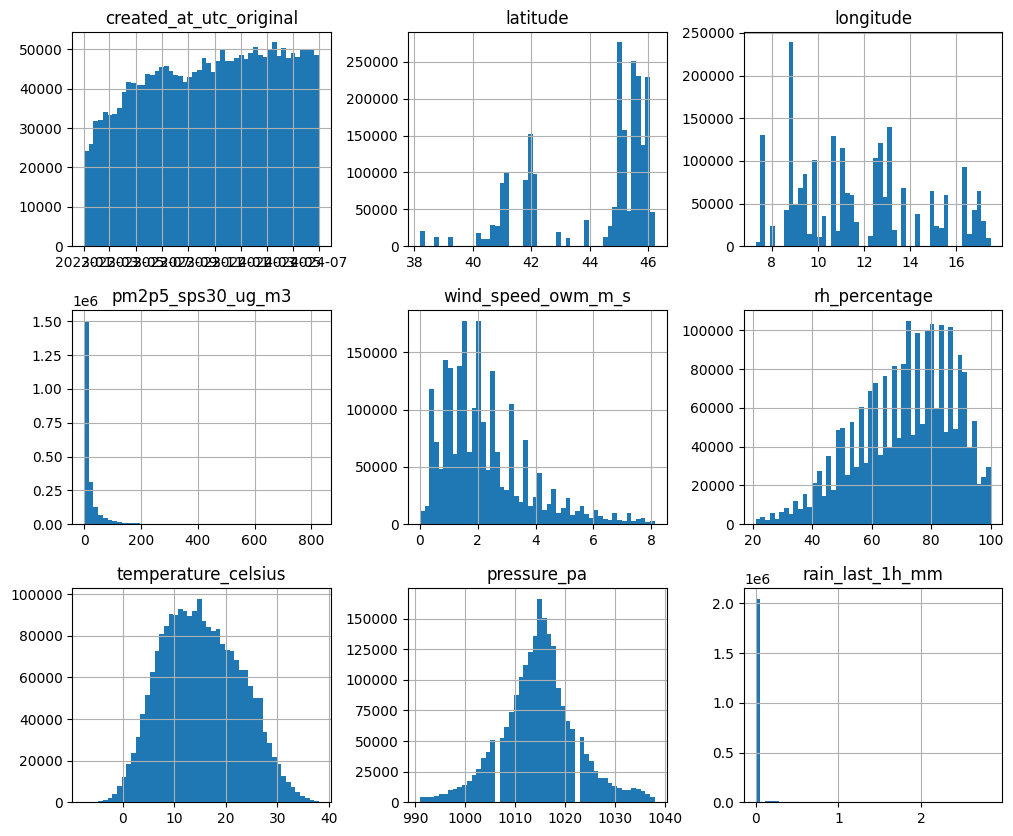

In [11]:
dataset_visualization.hist(bins=50, figsize=(12,10))

Visualizzazione del particolato PM2.5 rispetto alla posizione geografica

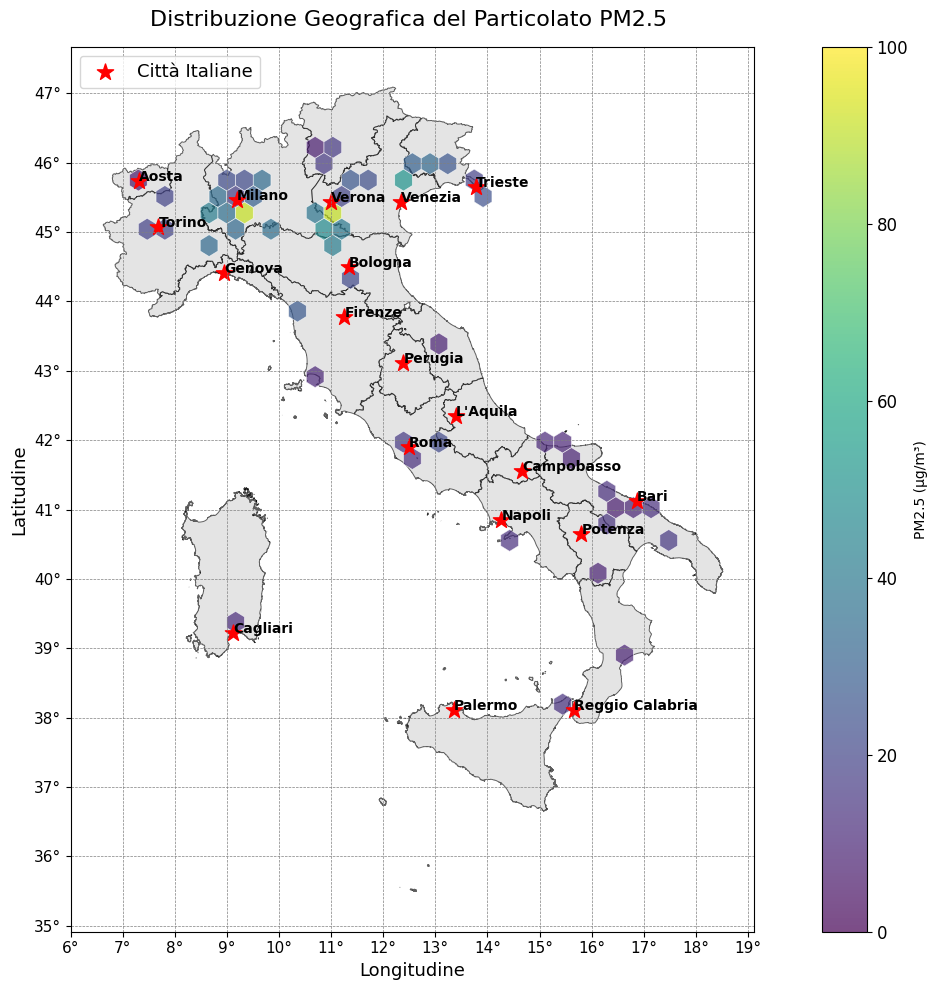

In [12]:
fig, ax = plt.subplots(figsize=(14, 10))

ripartizioni_geografiche.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.6, linewidth=0.7)
hexbin = ax.hexbin(
    x=dataset_visualization['longitude'],
    y=dataset_visualization['latitude'],
    C=dataset_visualization['pm2p5_sps30_ug_m3'],
    gridsize=30,
    cmap='viridis',
    reduce_C_function=np.mean,
    vmin=0, vmax=100,
    alpha=0.7,
    edgecolors='white',
    linewidths=0.5
)
ax.scatter(
    citta_italiane['longitude'], citta_italiane['latitude'],c="red", marker="*", s=150, label="Città Italiane")

for i, row in citta_italiane.iterrows():
    ax.text(
        row['longitude'], row['latitude'], row['citta'],
        fontsize=10, color="black", weight="bold", ha="left"
    )

cbar = plt.colorbar(hexbin, label='PM2.5 (µg/m³)')
cbar.ax.tick_params(labelsize=12)

ax.set_xticks(range(6, 20, 1))
ax.set_yticks(range(35, 48, 1))
ax.set_xticklabels([f"{i}°" for i in range(6, 20, 1)], fontsize=11)
ax.set_yticklabels([f"{i}°" for i in range(35, 48, 1)], fontsize=11)

ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

ax.set_title("Distribuzione Geografica del Particolato PM2.5 ", fontsize=16, pad=15)
ax.set_xlabel("Longitudine", fontsize=13)
ax.set_ylabel("Latitudine", fontsize=13)

ax.legend(loc="upper left", fontsize=13)
plt.tight_layout()

I valori medi di PM2.5 mostrati nel grafico sono più elevati nel Nord Italia e diminuiscono gradualmente spostandosi verso Sud.
La maggiore concentrazione di punti di rilevamento al Nord potrebbe essere indicativa di una maggiore presenza di stazioni di monitoraggio.

Visualizzazione del particolato PM2.5 rispetto alla temperatura

In [13]:
temperature_bins = range(
        int(dataset_visualization['temperature_celsius'].min()),
        int(dataset_visualization['temperature_celsius'].max()) + 3, 3)

dataset_visualization['temperature_bin'] = pd.cut( dataset_visualization['temperature_celsius'], bins=temperature_bins)

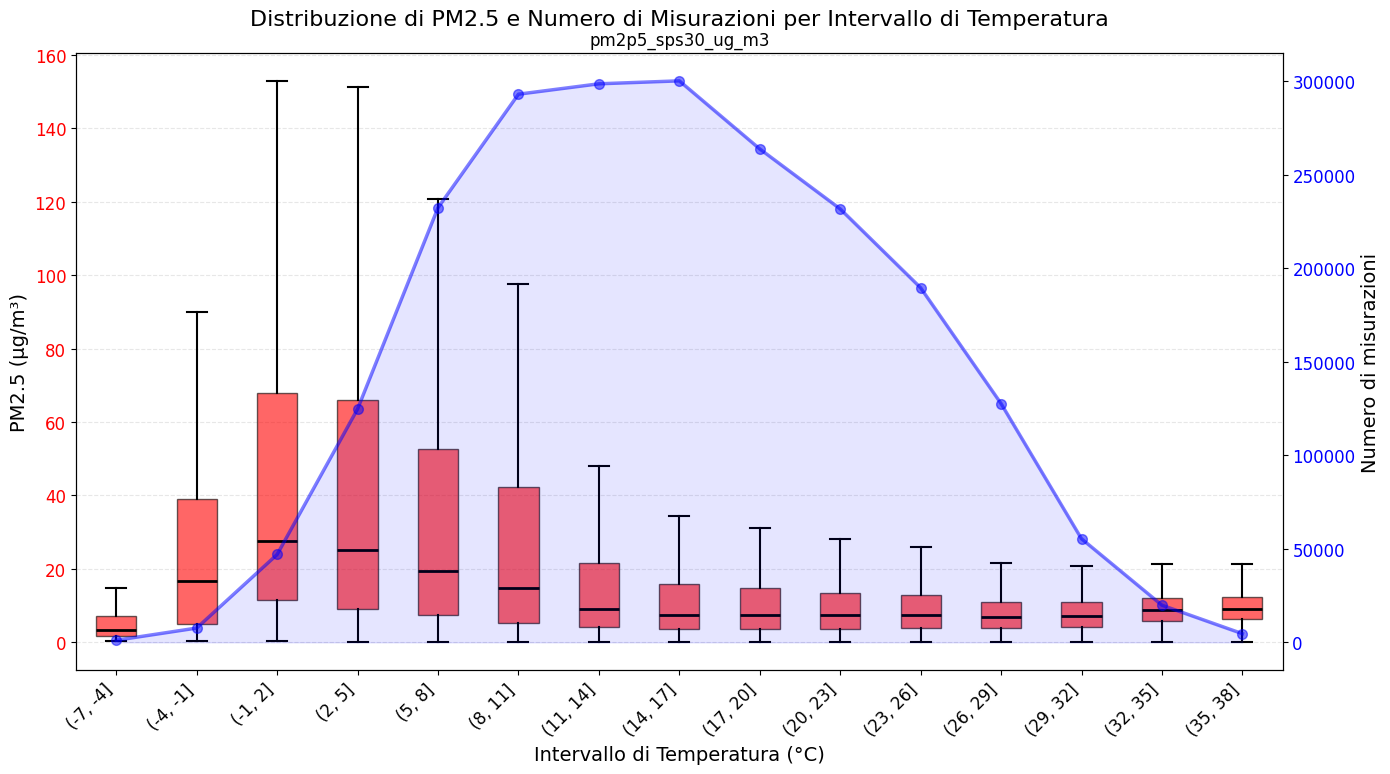

In [14]:
fig, ax1 = plt.subplots(figsize=(14, 8))
ax2 = ax1.twinx()

box = dataset_visualization.boxplot(
    column='pm2p5_sps30_ug_m3',
    by='temperature_bin',
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor='red', color='black', alpha=0.6),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    showfliers=False,
    ax=ax1
)

# Conteggio valori per bin
value_counts = dataset_visualization['temperature_bin'].value_counts().sort_index()
x = range(1, len(value_counts) + 1)
ax2.plot(x, value_counts.values, color='blue', marker='o', markersize=7, linewidth=2.5, label='Numero di misurazioni', alpha=0.5)
ax2.fill_between(x, value_counts.values, color='blue', alpha=0.1)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax1.set_xlabel('Intervallo di Temperatura (°C)', fontsize=14)
ax1.set_ylabel('PM2.5 (µg/m³)', fontsize=14)
ax2.set_ylabel('Numero di misurazioni', fontsize=14)
ax1.tick_params(axis='y', labelcolor='red', labelsize=12)
ax2.tick_params(axis='y', labelcolor='blue', labelsize=12)

ax1.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.title('Distribuzione di PM2.5 e Numero di Misurazioni per Intervallo di Temperatura', fontsize=16, pad=20)
plt.suptitle('')

plt.tight_layout()


Le concentrazioni di PM2.5 tendono ad aumentare significativamente quando le temperature scendono, specialmente al di sotto degli 11°C, mentre diminuiscono progressivamente con l'aumentare della temperatura. Questo fenomeno è strettamente legato alle dinamiche atmosferiche. Durante i periodi più caldi, favorisce la dispersione degli inquinanti.
Al contrario, quando le temperature si abbassano, gli inquinanti vengono intrappolati al suolo impedendone la dispersione.

Visualizzazione del particolato PM2.5 durante la giornata

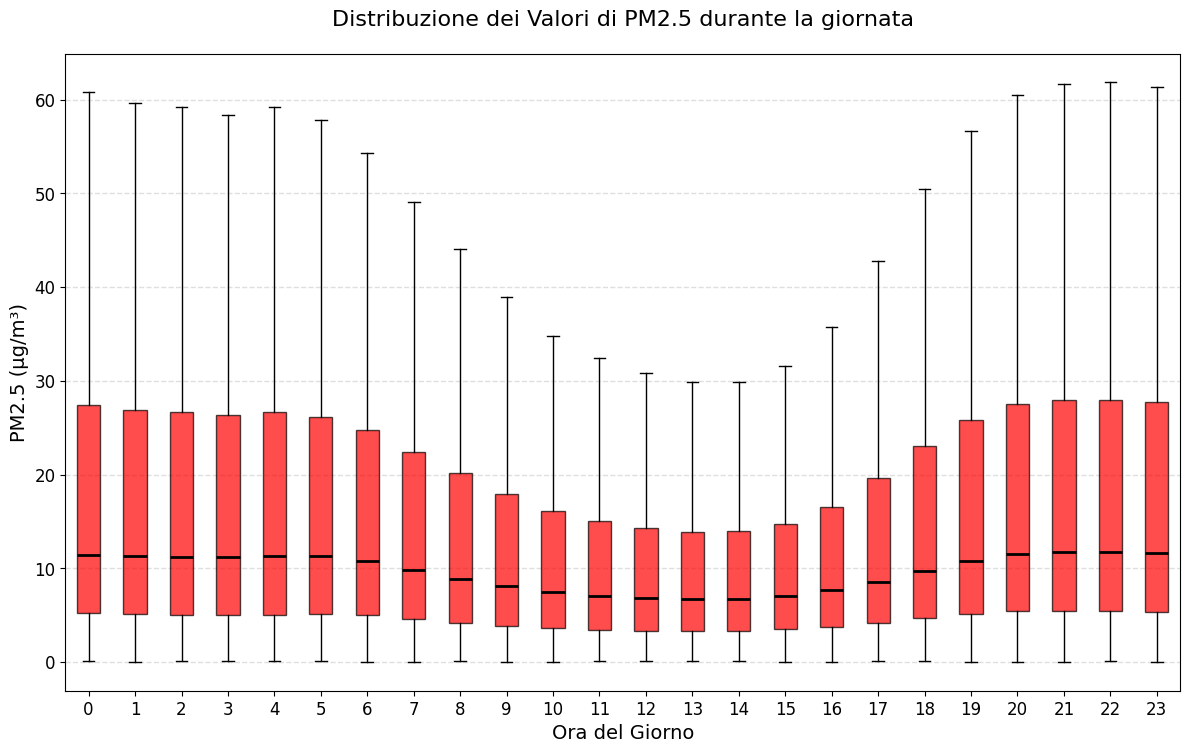

In [15]:
plt.figure(figsize=(12, 8))

dataset_visualization['hour'] = dataset_visualization['created_at_utc_original'].dt.hour

box = plt.boxplot([dataset_visualization[dataset_visualization['hour'] == h]['pm2p5_sps30_ug_m3'] for h in range(24)],
                  patch_artist=True,
                  boxprops=dict(facecolor='red', color='black', alpha=0.7),
                  medianprops=dict(color='black', linewidth=2),
                  showfliers=False)

plt.xlabel('Ora del Giorno', fontsize=14)
plt.ylabel('PM2.5 (µg/m³)', fontsize=14)
plt.title('Distribuzione dei Valori di PM2.5 durante la giornata', fontsize=16, pad=20)

plt.xticks(range(1, 25), range(24), fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, axis='y', linestyle='--', alpha=0.4, linewidth=1)

plt.tight_layout()
plt.subplots_adjust(bottom=0.13)

I livelli di PM2.5 sono più elevati durante le ore notturne e nelle prime ore del mattino (tra le 20 e le 7 del mattino), per poi diminuire nelle ore centrali della giornata.
Questa variazione è strettamente correlata all'andamento della temperatura che riduce la concentrazione del particolato.

Suddivido e rappresento le serie temporali per sensore

In [16]:
dataset_series=dataset.copy()

In [17]:
# Costruzione serie temporali per sensore
series_resampled = {}
sensor_id = dataset_series['device_id'].unique()
for device in sensor_id:
    device_df = dataset_series[dataset_series['device_id'] == device]
    device_df = device_df.set_index("created_at_utc_original").sort_index()

    series_resampled[device] = device_df[["pm2p5_sps30_ug_m3"]]

In [18]:
series_resampled[sensor_id[0]].head()

pm2p5_sps30_ug_m3
created_at_utc_original                   
2023-04-04 17:00:00                  11.13
2023-04-04 18:00:00                   9.32
2023-04-04 19:00:00                   6.41
2023-04-04 20:00:00                   6.79
2023-04-04 21:00:00                   6.29

Pulizia dei dati (Rimozione andamento costante o nullo)

In [19]:
series = {}
for device, device_series in series_resampled.items():
    device_series = device_series.dropna()

    # Calcola variazione tra misurazioni successive
    variation = device_series.diff().abs()

    # Identifica i periodi attivi (non costanti)
    active_periods = variation["pm2p5_sps30_ug_m3"] > 0.00
    series[device] = device_series[active_periods]


print(sensor_id[0])
print(series[sensor_id[0]].head())
print("Numero di serie temporali (dispositivi):", len(series))

ari-1009
                         pm2p5_sps30_ug_m3
created_at_utc_original                   
2023-04-04 18:00:00                   9.32
2023-04-04 19:00:00                   6.41
2023-04-04 20:00:00                   6.79
2023-04-04 21:00:00                   6.29
2023-04-04 22:00:00                   5.55
Numero di serie temporali (dispositivi): 326


In [20]:
# Definizione degli intervalli di esclusione
exclude_start_1 = pd.to_datetime('2023-10-01')
exclude_start_2 = pd.to_datetime('2023-07-01')
exclude_end_3 = pd.to_datetime('2023-06-01')

# Scarto completamente ari-1505
series.pop('ari-1033', None)
series.pop('ari-1505', None)
series.pop('ari-1202', None)

# Filtra e rimuovi le parti escluse
series['ari-1062'] = series['ari-1062'].drop(series['ari-1062'].loc[(series['ari-1062'].index >= exclude_start_1)].index)
series['ari-1066'] = series['ari-1066'].drop(series['ari-1066'].loc[series['ari-1066'].index >= exclude_start_2].index)


Visualizzazione serie temporali per sensori

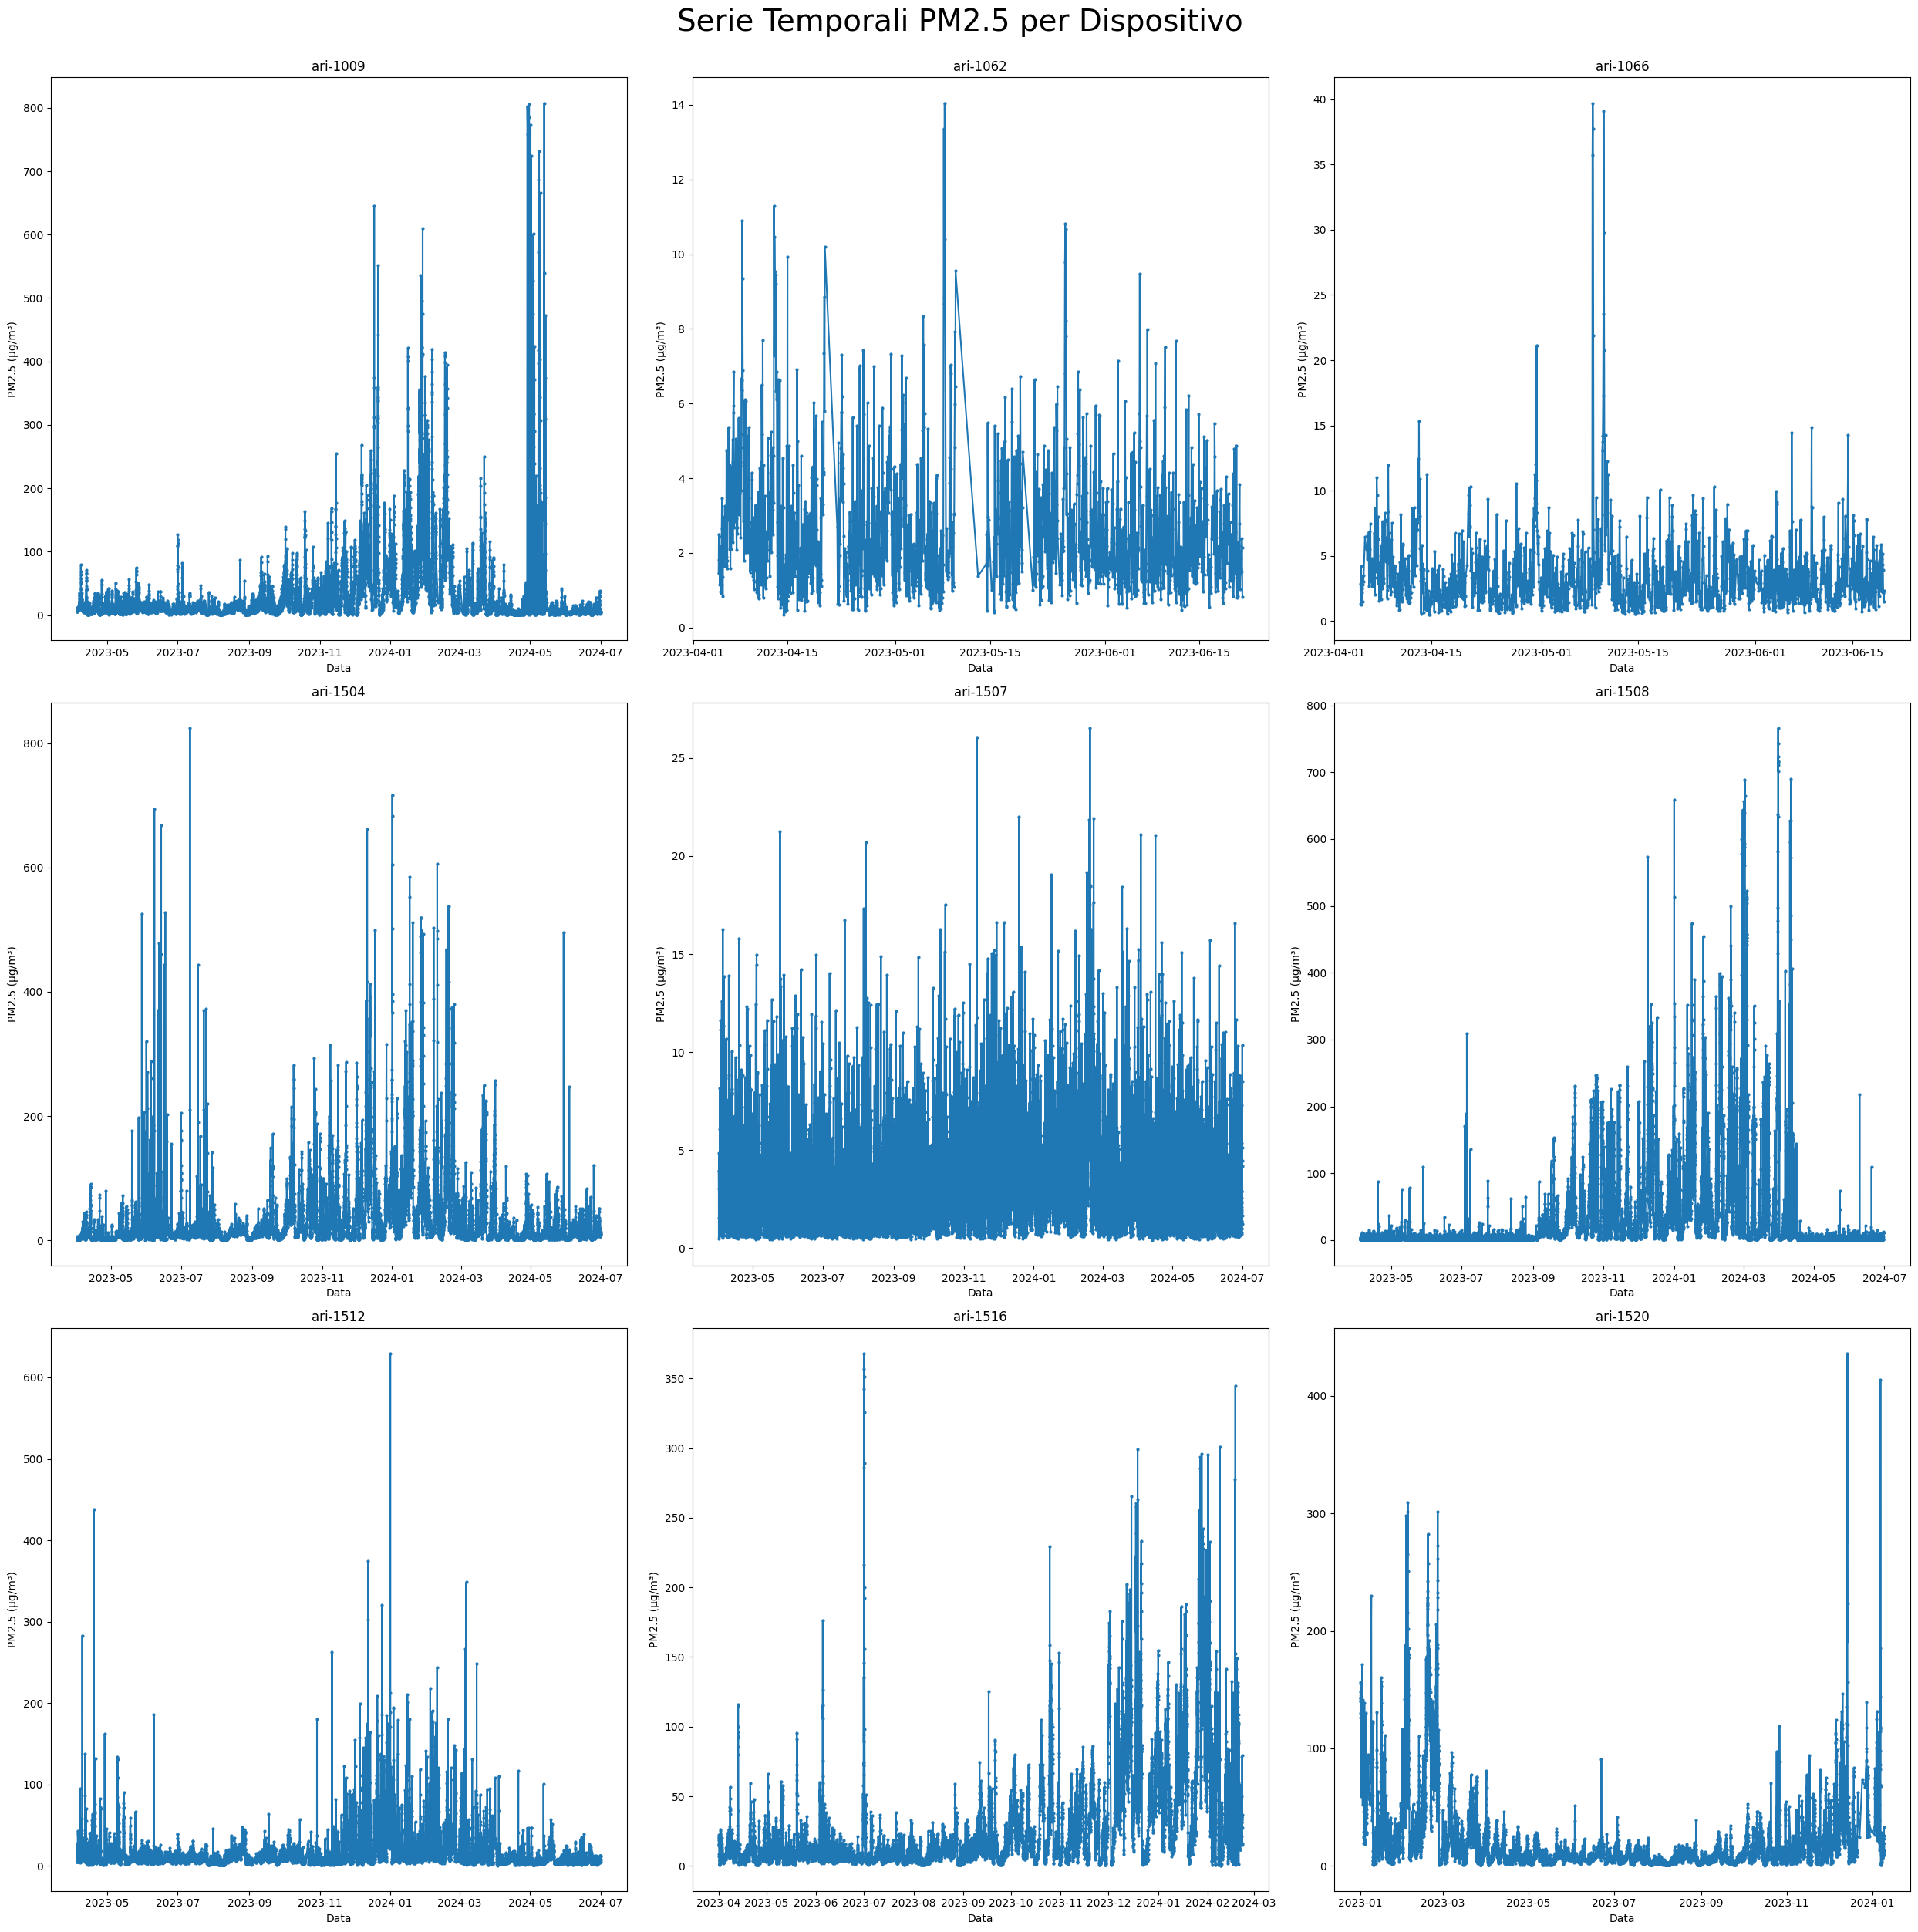

In [21]:
# Creazione Griglia per visualizzazione serie temporali
n_rows, n_cols = 3,3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 25))

for i in range(n_rows):
    for j in range(n_cols):
        index = i * n_cols + j

        if index >= len(list(series.keys())):
            axs[i, j].axis('off')
            continue

        device_id = list(series.keys())[index]
        device_series = series[device_id]["pm2p5_sps30_ug_m3"]

        axs[i, j].plot(device_series.index, device_series.values, marker='o', linestyle='-', markersize=2)
        axs[i, j].set_title(device_id)
        axs[i, j].set_xlabel('Data')
        axs[i, j].set_ylabel('PM2.5 (µg/m³)')
        axs[i, j].xaxis_date()

fig.suptitle('Serie Temporali PM2.5 per Dispositivo', fontsize=28, y=1)
plt.tight_layout()


C'è una notevole variazione nella concentrazione di PM2.5 tra i sensori. Alcuni mostrano picchi molto alti("ari-1504" e "ari-1508"), mentre altri mantengono livelli bassi o quasi costanti("ari-1062").Inoltre, alcune serie presentano interruzioni evidenti, suggerendo che i sensori potrebbero aver avuto malfunzionamenti o periodi di inattività.

I sensori presi in considerazione hanno registrazioni di date simili, suggerendo che i dati siano stati raccolti simultaneamente. Tuttavia, la precisione temporale varia nel dataset.

Confronto serie temporali ('ari-1507', 'ari-1630')

In [22]:
device_id_1 = 'ari-1507'
device_id_2 = 'ari-1630'

# Verifico coordinate uguali/simili tra i due dispostivi
coords_1 = dataset_series.loc[dataset_series['device_id'] == device_id_1, ['latitude', 'longitude']].drop_duplicates()
coords_2 = dataset_series.loc[dataset_series['device_id'] == device_id_2, ['latitude', 'longitude']].drop_duplicates()
print("ari-1507", coords_1)
print("ari-1630", coords_2)

series_1 = series[device_id_1]["pm2p5_sps30_ug_m3"]
series_2 = series[device_id_2]["pm2p5_sps30_ug_m3"]

# Filtro il periodo
start_date = '2023-05-01'
end_date = '2023-09-30'
series_1_period = series_1.loc[start_date:end_date]
series_2_period = series_2.loc[start_date:end_date]

ari-1507             latitude  longitude
device_id                      
ari-1507   45.053299   7.708379
ari-1630             latitude  longitude
device_id                      
ari-1630   45.083797   7.685046


<Figure size 1400x700 with 0 Axes>

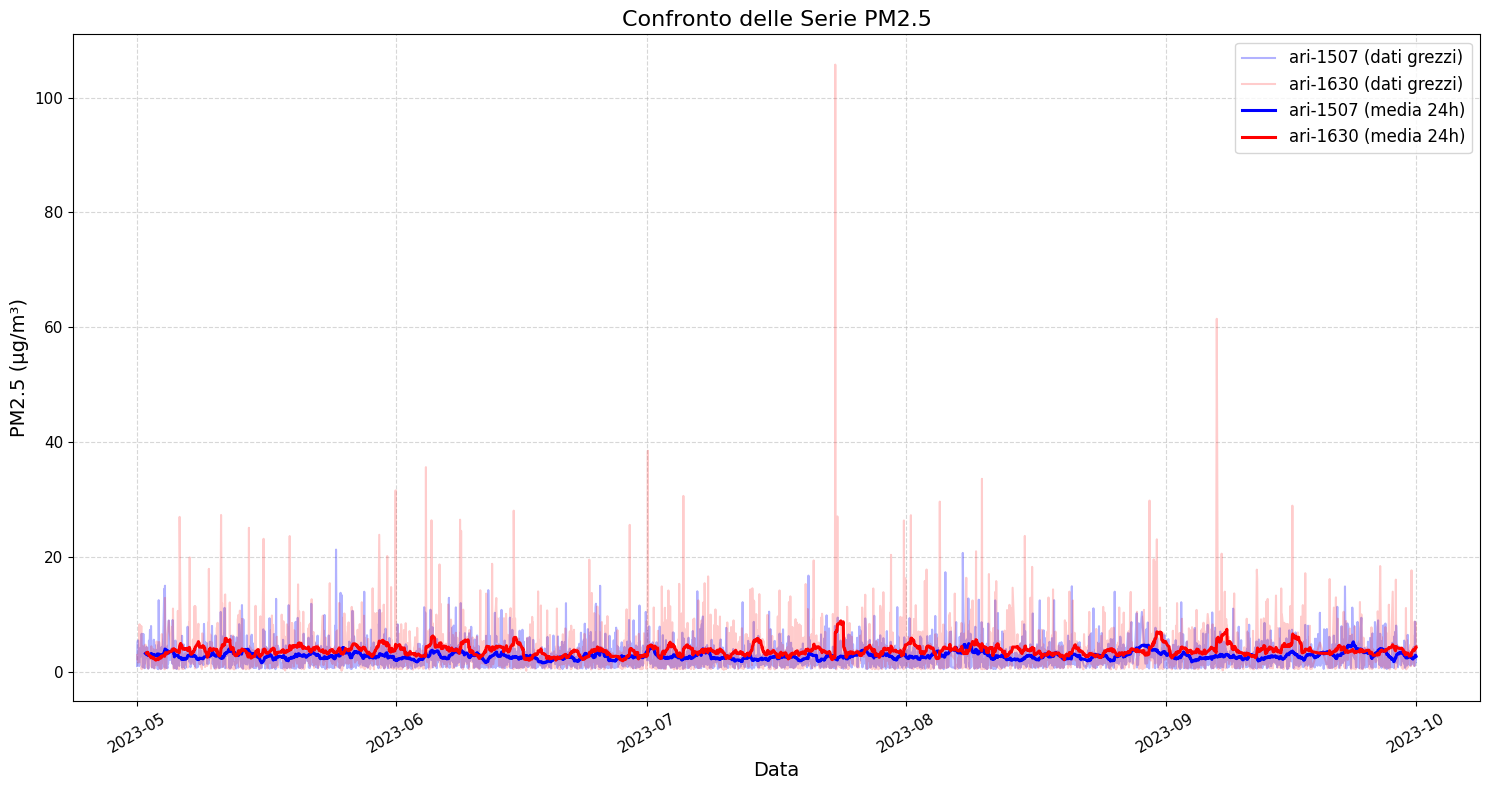

In [23]:
plt.figure(figsize=(14, 7))

# Calcola la media giornaliera
rolling_1 = series_1_period.rolling(window=24).mean()
rolling_2 = series_2_period.rolling(window=24).mean()

plt.figure(figsize=(15, 8))
plt.plot(series_1_period.index, series_1_period.values, label=f'{device_id_1} (dati grezzi)', color='blue', alpha=0.3)
plt.plot(series_2_period.index, series_2_period.values, label=f'{device_id_2} (dati grezzi)', color='red', alpha=0.2)
plt.plot(rolling_1.index, rolling_1.values, label=f'{device_id_1} (media 24h)', color='blue', linewidth=2.2)
plt.plot(rolling_2.index, rolling_2.values, label=f'{device_id_2} (media 24h)', color='red', linewidth=2.2)


plt.xlabel('Data', fontsize=14)
plt.ylabel('PM2.5 (µg/m³)', fontsize=14)
plt.title('Confronto delle Serie PM2.5', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=11, rotation=30)
plt.yticks(fontsize=11)
plt.tight_layout()


Entrambe le serie di dati, presentano livelli relativamente bassi e oscillazioni simili nella maggior parte del periodo analizzato.
Tuttavia, la serie rossa ("ari-1630") presenta picchi di maggiore intensità rispetto alla serie blu ('ari-1507').

In particolare, la serie rossa mostra due picchi estremamente elevati, questi potrebbero essere dovuti a un evento di inquinamento eccezionale oppure un errore nei dati.

# PreProcessing

In [24]:
dataset_preprocessing=dataset.copy()

Rappresento matrice di correlazione, utile per identificare relazioni tra variabili.

<Axes: >

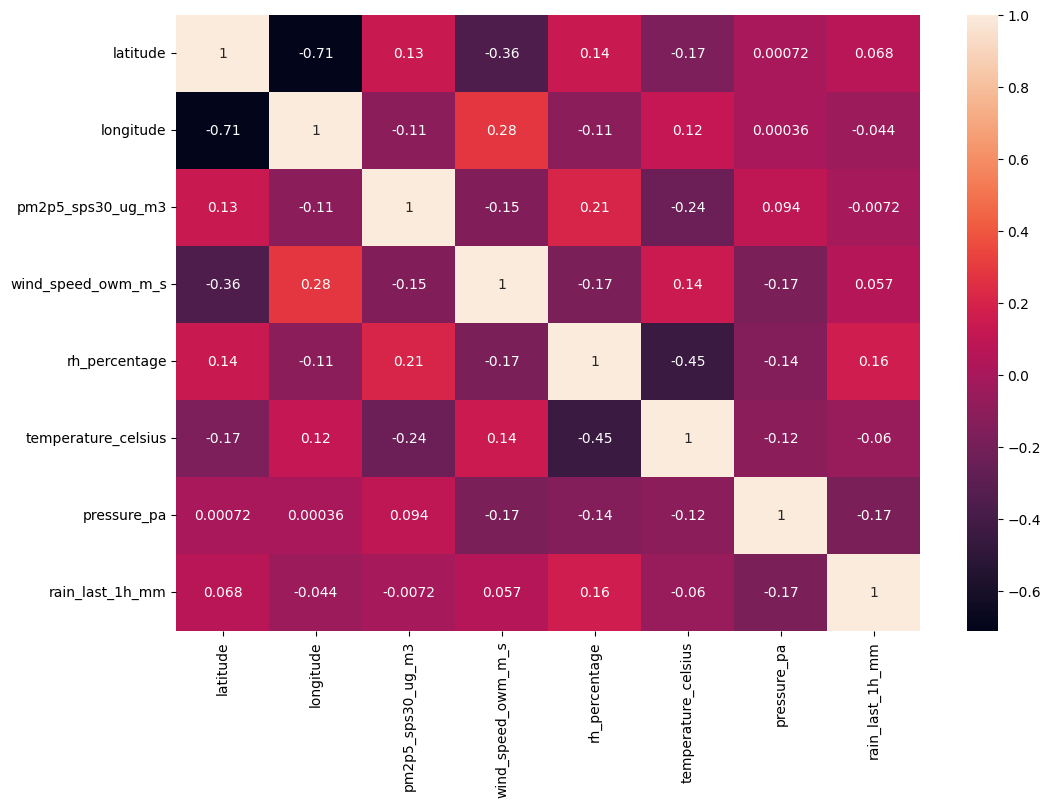

In [25]:
plt.figure(figsize = (12,8))

features = ['latitude', 'longitude', 'pm2p5_sps30_ug_m3', 'wind_speed_owm_m_s', 'rh_percentage', 'temperature_celsius', 'pressure_pa', 'rain_last_1h_mm']
corr_matrix = dataset_preprocessing[features].corr()
sea.heatmap(corr_matrix, annot=True)

L'analisi dei dati rivela l'assenza di forti correlazioni tra le variabili.

- Umidità e temperatura: Esiste una correlazione negativa tra umidità (rh_percentage) e temperatura (temperature_celsius). Ciò significa che, in generale, l'umidità tende a diminuire all'aumentare della temperatura.
- Temperatura e PM2.5: La temperatura mostra una correlazione negativa con il PM2.5. Ciò suggerisce che, all'aumentare della temperatura, i livelli di PM2.5 tendono a diminuire,

Dall'analisi visiva, sembra che i livelli di PM2.5 peggiorino con l'aumento dell'umidità, mentre migliorino con l'aumento della temperatura e della velocità del vento.
Questo potrebbe indicare che condizioni di alta umidità favoriscono l'accumulo di particolato, mentre il vento contribuisce a disperderlo.

Suddivido le serie temporali per sensore

In [26]:
# Selezione delle feature
features = [
    'pm2p5_sps30_ug_m3',
    'wind_speed_owm_m_s',
    'rh_percentage',
    'temperature_celsius',
    'pressure_pa',
    'rain_last_1h_mm'
]

Resampling Temporale Giornaliero dei Dati Sensore

In [27]:
print("Numero istanze (pre Resampling) nel dataset:", dataset_preprocessing.shape[0])

series = {}
sensor_id = dataset_preprocessing['device_id'].unique()
for device_id in sensor_id:
    device_data = dataset_preprocessing[dataset_preprocessing["device_id"] == device_id]
    device_data = device_data.set_index("created_at_utc_original").sort_index()

    # Resampling giornaliero
    series[device_id] = device_data.resample("D").nearest()

print("Numero istanze (post Resampling) nel dataset:", sum([seriesconcat.shape[0] for seriesconcat in series.values()]))

print(sensor_id[0])
print(series[sensor_id[0]].head())
print("Numero di serie temporali(dispositivi):", len(series))


Numero istanze (pre Resampling) nel dataset: 2196839
Numero istanze (post Resampling) nel dataset: 95958
ari-1009
                        device_id   latitude  longitude  pm2p5_sps30_ug_m3  \
created_at_utc_original                                                      
2023-04-04               ari-1009  45.456144   9.115223              11.13   
2023-04-05               ari-1009  45.456144   9.115223               6.30   
2023-04-06               ari-1009  45.456144   9.115223               9.77   
2023-04-07               ari-1009  45.456144   9.115223              17.82   
2023-04-08               ari-1009  45.456144   9.115223              33.23   

                         wind_speed_owm_m_s  rh_percentage  \
created_at_utc_original                                      
2023-04-04                             2.06           36.0   
2023-04-05                             3.09           72.0   
2023-04-06                             2.24           49.0   
2023-04-07                   

In [28]:
missing_devices = set(dataset_preprocessing["device_id"].unique()) - set(series.keys())
print(f"Dispositivi mancanti ({len(missing_devices)}):", missing_devices)


Dispositivi mancanti (0): set()


In [29]:
# Creo Series_anlysis per poter fare analisi su cluster successivamente
series_analysis = copy.deepcopy(series)


Standardizzazione delle Variabili Numeriche.
Trasformazione delle feature per ottenere una distribuzione con media nulla e varianza unitaria, consentendo la comparabilità tra variabili su scale diverse.

In [30]:
# Applicazione dello Standardscaler
scaler = StandardScaler()
for device_id in series:
    device_df = series[device_id]
    device_df[features] = scaler.fit_transform(device_df[features])

    series[device_id] = device_df


print(f"Device ID: {sensor_id[0]}")
print(series[sensor_id[0]].head())


Device ID: ari-1009
                        device_id   latitude  longitude  pm2p5_sps30_ug_m3  \
created_at_utc_original                                                      
2023-04-04               ari-1009  45.456144   9.115223          -0.487890   
2023-04-05               ari-1009  45.456144   9.115223          -0.564122   
2023-04-06               ari-1009  45.456144   9.115223          -0.509355   
2023-04-07               ari-1009  45.456144   9.115223          -0.382302   
2023-04-08               ari-1009  45.456144   9.115223          -0.139086   

                         wind_speed_owm_m_s  rh_percentage  \
created_at_utc_original                                      
2023-04-04                         0.213324      -3.381438   
2023-04-05                         1.112093      -0.565468   
2023-04-06                         0.370390      -2.364560   
2023-04-07                        -0.240424      -1.347682   
2023-04-08                        -1.139194       0.373188   

Riduzione dimensionale per il clustering

In [31]:
## Concateniamo tutte le serie temporali in un unico DataFrame
data_clustering = pd.concat([series[device_id][features] for device_id in series.keys()])

print(data_clustering.head())


                         pm2p5_sps30_ug_m3  wind_speed_owm_m_s  rh_percentage  \
created_at_utc_original                                                         
2023-04-04                       -0.487890            0.213324      -3.381438   
2023-04-05                       -0.564122            1.112093      -0.565468   
2023-04-06                       -0.509355            0.370390      -2.364560   
2023-04-07                       -0.382302           -0.240424      -1.347682   
2023-04-08                       -0.139086           -1.139194       0.373188   

                         temperature_celsius  pressure_pa  rain_last_1h_mm  
created_at_utc_original                                                     
2023-04-04                         -0.281095    -0.154913        -0.280362  
2023-04-05                         -1.177322     0.521343        -0.280362  
2023-04-06                         -1.234851     0.656594        -0.280362  
2023-04-07                         -0.874543   

In [32]:
pca = PCA(n_components=0.85)
series_data_pca = pca.fit_transform(data_clustering)

pca_df = pd.DataFrame(series_data_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=data_clustering.index)
pca_df

PC1       PC2       PC3       PC4       PC5
created_at_utc_original                                                  
2023-04-04              -0.895750 -2.268656  1.265805  0.405620 -0.027379
2023-04-05              -0.119235 -0.424449  1.691716 -0.464176 -0.565750
2023-04-06              -0.003581 -1.690130  1.849651  0.249255 -0.601051
2023-04-07               0.204894 -0.989083  0.801861  0.115945 -0.665415
2023-04-08               1.121514  0.110214 -0.271862 -0.017131 -1.058405
...                           ...       ...       ...       ...       ...
2024-06-26              -1.044342 -0.336789 -1.108232 -0.050773  0.512415
2024-06-27              -0.650868 -0.020543 -1.886317  0.041054  0.297334
2024-06-28              -0.655871 -1.402130 -1.326429  0.722002  0.270193
2024-06-29              -1.695390 -1.168122 -0.185072  0.092717  1.263115
2024-06-30              -0.507629 -1.667828 -1.339334  0.923258  0.274029

[95958 rows x 5 columns]

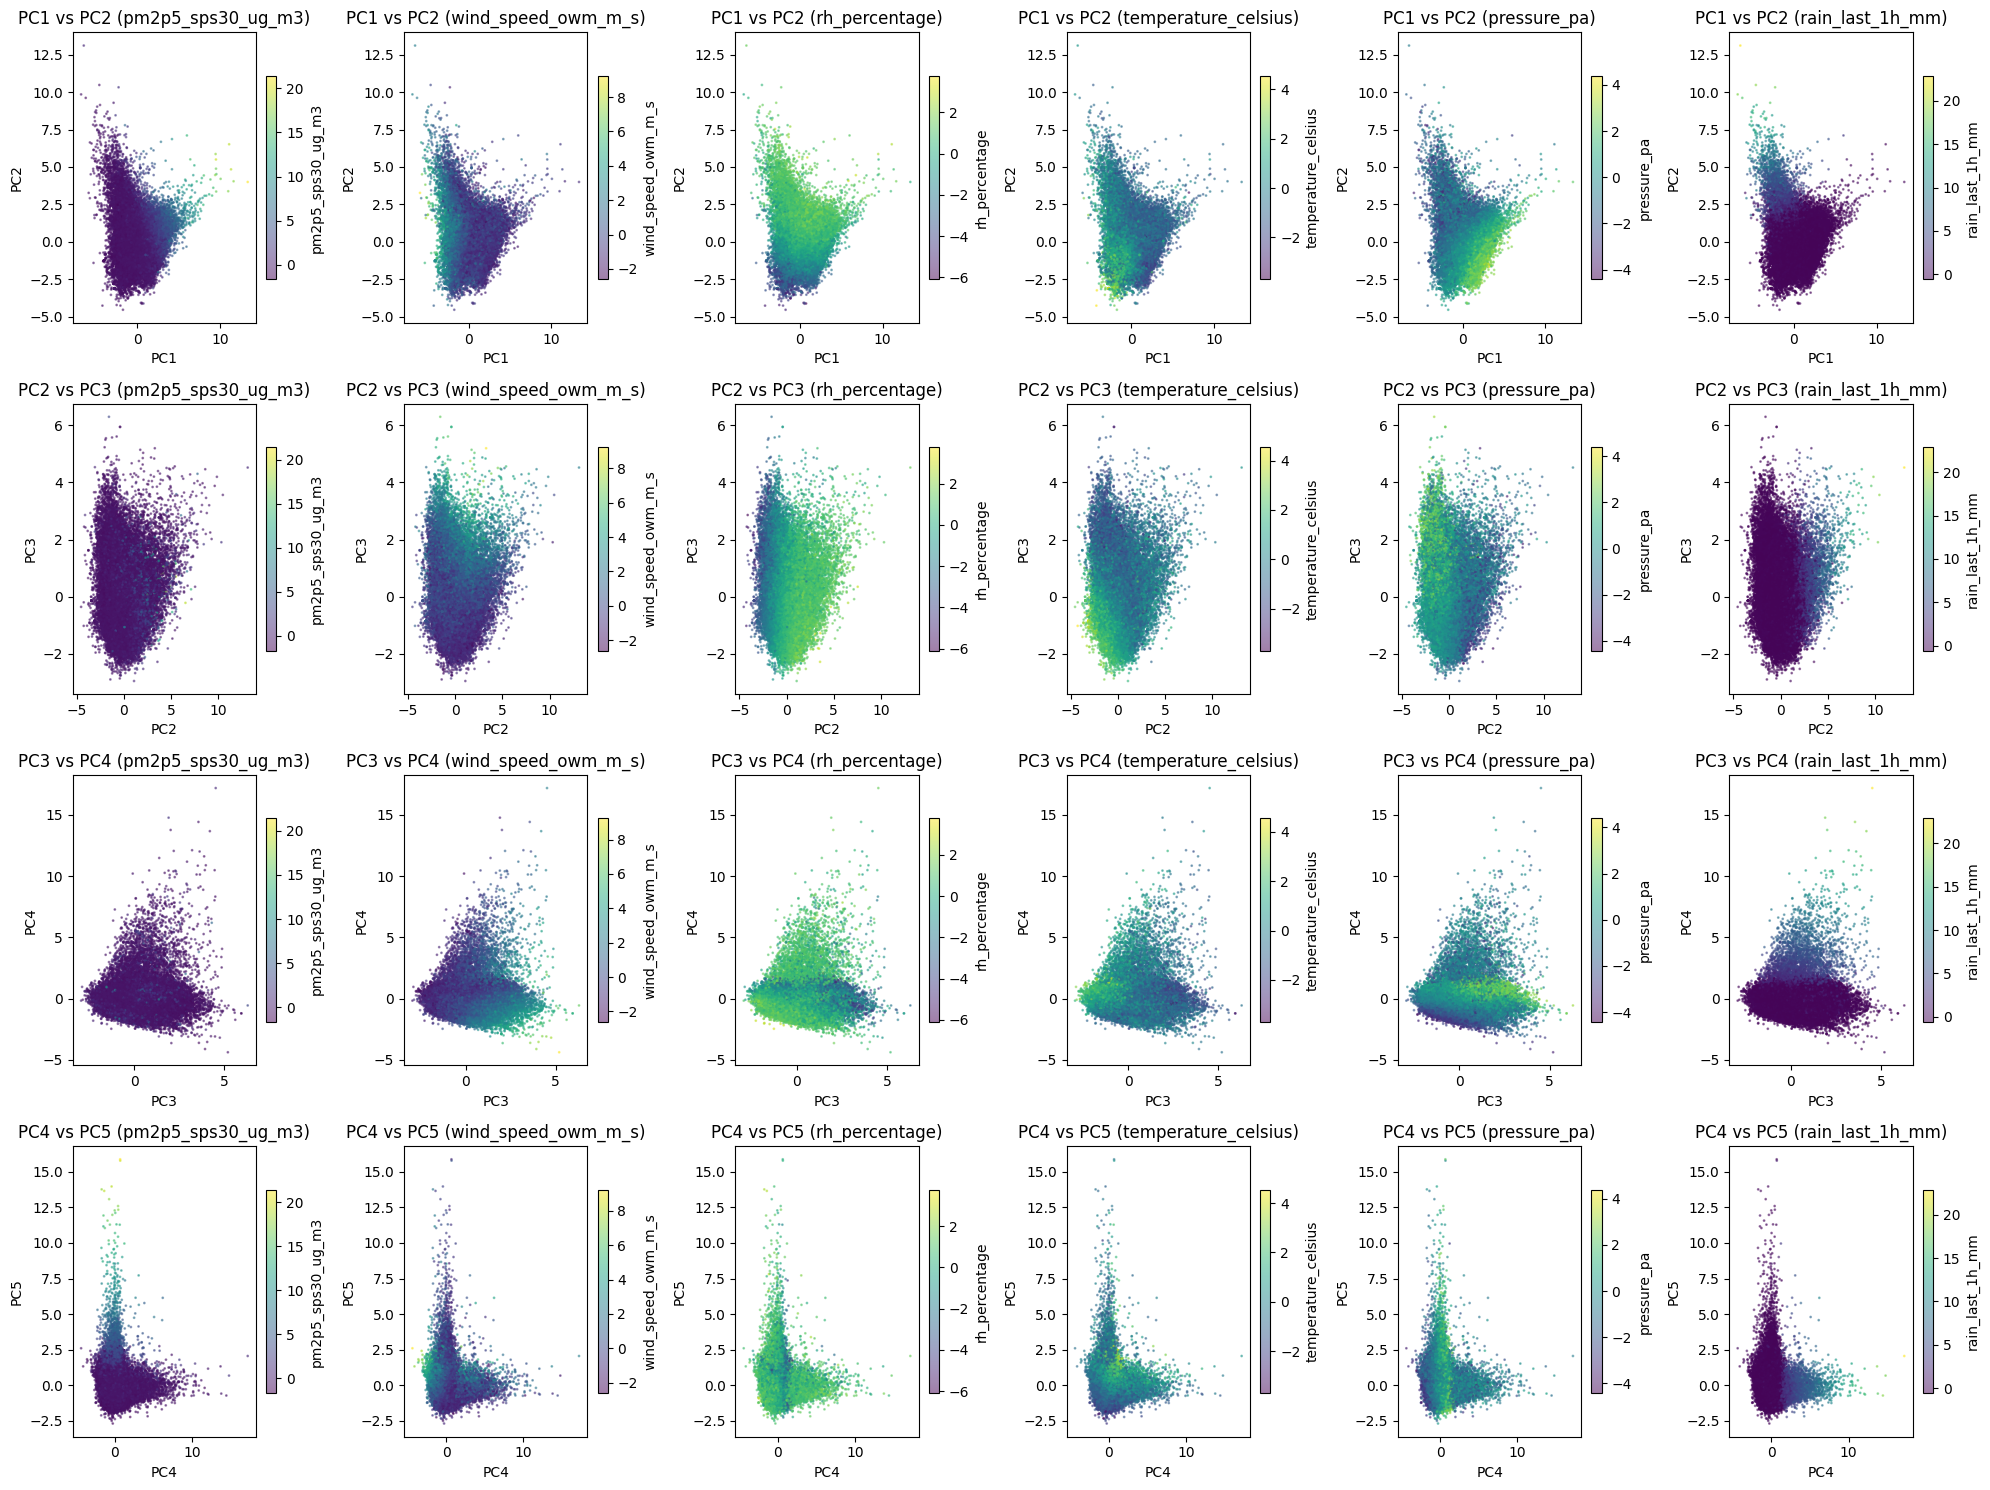

In [33]:
components = pca_df.columns

# Creao un grid plot per confrontare le componenti principali
fig, axes = plt.subplots(len(components) - 1, len(features), figsize=(20, 15), sharex=False, sharey=False)

for i, comp_x in enumerate(components[:-1]):
    for j, feature in enumerate(features):
        comp_y = components[i + 1]
        ax = axes[i, j]

        scatter = ax.scatter(pca_df[comp_x], pca_df[comp_y], c=data_clustering[feature], cmap='viridis', alpha=0.5, s=1)

        ax.set_xlabel(comp_x)
        ax.set_ylabel(comp_y)
        ax.set_title(f'{comp_x} vs {comp_y} ({feature})')

        cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.05, pad=0.05)
        cbar.set_label(feature)

plt.tight_layout()

[0.25717826 0.22652828 0.15715371 0.13489735 0.1236312 ]
[1.54135157 1.35765646 0.94187243 0.80848295 0.74096136]
Components: 5
Errore di ricostruzione: 0.10049814414036189
Varianza spiegata totale: 0.8993887934597138


Text(0.5, 1.0, 'Varianza spiegata cumulativa')

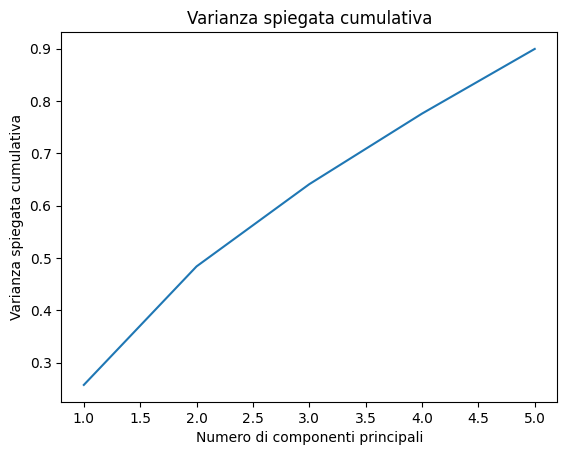

In [34]:
# Ricostruisci i dati originali a partire dalle componenti principali
reconstructed_data = pca.inverse_transform(series_data_pca)

# Calcola l'errore di ricostruzione (differenza tra i dati originali e ricostruiti)
reconstruction_error = np.mean((data_clustering - reconstructed_data) ** 2)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)
print("Components:",pca.n_components_)
print("Errore di ricostruzione:", reconstruction_error)
print(f"Varianza spiegata totale: {np.sum(pca.explained_variance_ratio_)}")

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('Varianza spiegata cumulativa')

## Model Selection

Scelgo gli algoritmi più adatti a una serie temporale, che meglio combinano variabili metereologiche e misure del particolato:
- K-Means
- Agglomerative Clustering
- Spectral Clustering

In [35]:
# Valore simbolico sample
sampled_data_pca_agg = series_data_pca[:20000]
sampled_data_pca_spec = series_data_pca[:10000]

print("Dimensione del campione Agglomerative:", sampled_data_pca_agg.shape)
print("Dimensione del campione Spectral:", sampled_data_pca_spec.shape)
print("Dimensione del dataset:", series_data_pca.shape)

Dimensione del campione Agglomerative: (20000, 5)
Dimensione del campione Spectral: (10000, 5)
Dimensione del dataset: (95958, 5)


### KMEANS

Elbow Method per trovare il numero ottimale di cluster

WCSS = Somma delle distanze al quadrato  tra ciascun punto del dataset e il centroide del cluster

Silhouette Score = Misura la qualità dei cluster calcolando quanto bene ogni punto è assegnato al proprio cluster rispetto ai cluster vicini

Silhouette Score per K-Means con 4 cluster: 0.2073
Silhouette Score per K-Means con 5 cluster: 0.2303
Silhouette Score per K-Means con 6 cluster: 0.2367
Silhouette Score per K-Means con 7 cluster: 0.2083
Silhouette Score per K-Means con 8 cluster: 0.1996


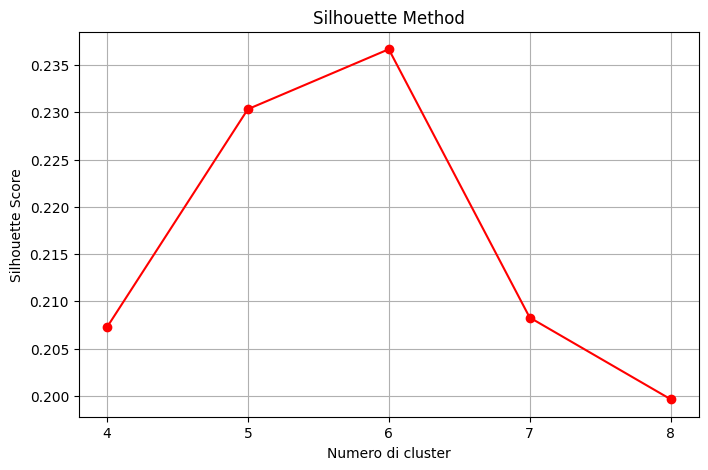

In [36]:
K = range(4, 9)
silhouette_scores = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(series_data_pca)

    # Prendo un campione del 40% dei dati
    sample_indices = np.random.choice(len(series_data_pca), size=int(0.4 * len(series_data_pca)), replace=False)
    sample_data = series_data_pca[sample_indices]
    sample_labels = labels[sample_indices]

    score = silhouette_score(sample_data, sample_labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score per K-Means con {k} cluster: {score:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Numero di cluster')
plt.xticks(K, K)
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.grid()

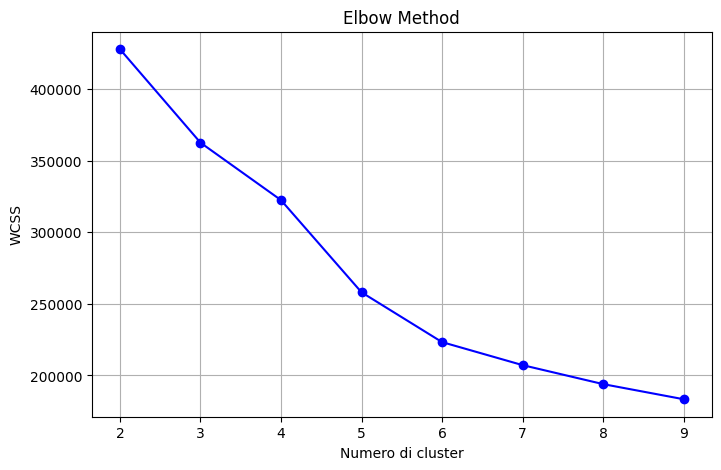

In [37]:
K=range(2, 10)
wcss = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(series_data_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.grid()

In [38]:
# Numero di cluster
n_clusters_kmeans = 6

# Applicazione algoritmo K-Means
kmeans_model = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
labels_kmeans = kmeans_model.fit_predict(series_data_pca)

pca_df['Cluster K-Means'] = labels_kmeans
clustered_devices_kmeans = {idx: int(label) for idx, label in enumerate(labels_kmeans)}

print("Numero di cluster:", n_clusters_kmeans)
print("Cluster dei dispositivi:", clustered_devices_kmeans)
print("Numero di dispositivi per cluster:\n", pd.Series(labels_kmeans).value_counts().sort_index())

Numero di cluster: 6
Cluster dei dispositivi: {0: 5, 1: 1, 2: 1, 3: 1, 4: 2, 5: 0, 6: 0, 7: 1, 8: 2, 9: 2, 10: 2, 11: 5, 12: 0, 13: 0, 14: 1, 15: 5, 16: 0, 17: 2, 18: 2, 19: 2, 20: 2, 21: 0, 22: 2, 23: 5, 24: 5, 25: 5, 26: 5, 27: 5, 28: 2, 29: 2, 30: 5, 31: 5, 32: 5, 33: 5, 34: 5, 35: 0, 36: 0, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 5, 46: 2, 47: 2, 48: 2, 49: 5, 50: 5, 51: 2, 52: 2, 53: 5, 54: 0, 55: 5, 56: 5, 57: 0, 58: 5, 59: 5, 60: 5, 61: 0, 62: 2, 63: 2, 64: 5, 65: 5, 66: 5, 67: 5, 68: 0, 69: 0, 70: 5, 71: 2, 72: 5, 73: 5, 74: 5, 75: 5, 76: 5, 77: 5, 78: 5, 79: 5, 80: 5, 81: 5, 82: 5, 83: 5, 84: 5, 85: 0, 86: 5, 87: 5, 88: 2, 89: 5, 90: 5, 91: 0, 92: 0, 93: 5, 94: 5, 95: 5, 96: 5, 97: 5, 98: 5, 99: 5, 100: 2, 101: 5, 102: 5, 103: 5, 104: 5, 105: 5, 106: 5, 107: 5, 108: 5, 109: 5, 110: 5, 111: 5, 112: 2, 113: 0, 114: 5, 115: 5, 116: 5, 117: 0, 118: 5, 119: 0, 120: 5, 121: 5, 122: 5, 123: 4, 124: 5, 125: 0, 126: 5, 127: 5, 128: 5, 129: 5, 130: 5, 131: 5, 132: 5,

### Agglomerative Clustering

Dendrogramma per Agglomerative Clustering

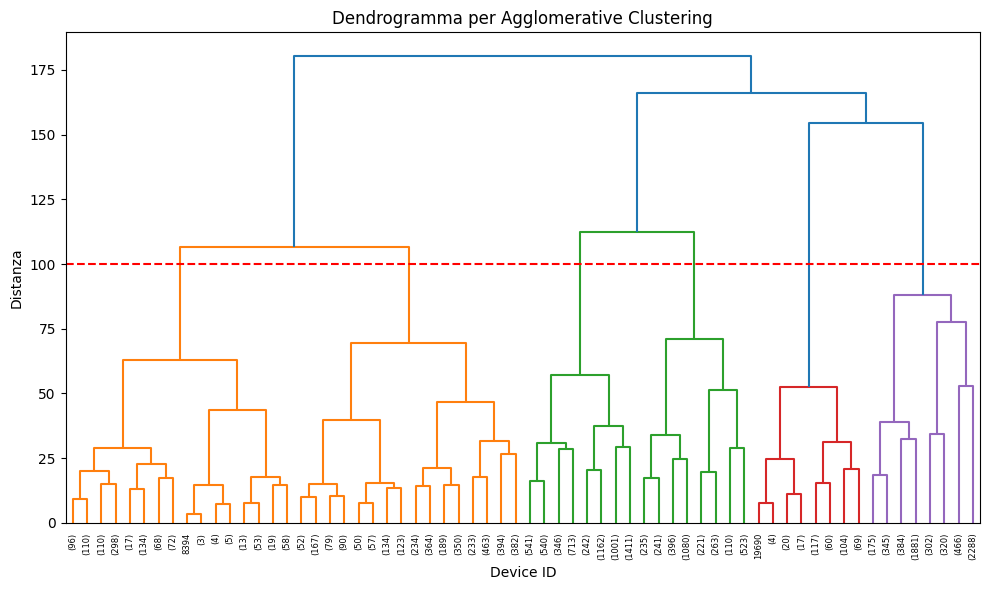

In [39]:
plt.figure(figsize=(10, 6))

dendrogram(linkage(sampled_data_pca_agg, method='ward'), truncate_mode='level', p=5)

plt.axhline(y=100, color='red', linestyle='--')

plt.title("Dendrogramma per Agglomerative Clustering")
plt.xlabel("Device ID")
plt.ylabel("Distanza")
plt.xticks(rotation=90)
plt.tight_layout()


Il dendrogramma rappresenta la gerarchia dei cluster formati durante il processo di clustering gerarchico.

Analizzando il grafico, si può osservare che il numero ottimale di cluster è 6, poiché questa scelta corrisponde ai primi livelli di taglio significativi, prima che i cluster si suddividano in gruppi più piccoli e meno distinti.

In [40]:
# Numero di cluster (dendeogramma)
n_clusters_agg = 6

# Applicazione algoritmo Agglomerative Clustering
agglomerative_model = AgglomerativeClustering(n_clusters=n_clusters_agg, linkage='ward')
#labels_agg = agglomerative_model.fit_predict(series_data_pca)
labels_agg = agglomerative_model.fit_predict(sampled_data_pca_agg)

#pca_df['Cluster Agglomerative'] = labels_agg
clustered_devices_agg = {idx: int(label) for idx, label in enumerate(labels_agg)}

print("Numero di cluster:", n_clusters_agg)
print("Cluster dei dispositivi:", clustered_devices_agg)
print("Numero di dispositivi per cluster:\n", pd.Series(labels_agg).value_counts().sort_index())

Numero di cluster: 6
Cluster dei dispositivi: {0: 1, 1: 1, 2: 2, 3: 2, 4: 2, 5: 1, 6: 1, 7: 4, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 1, 14: 1, 15: 1, 16: 0, 17: 0, 18: 2, 19: 4, 20: 0, 21: 0, 22: 0, 23: 4, 24: 1, 25: 4, 26: 4, 27: 4, 28: 0, 29: 4, 30: 4, 31: 4, 32: 1, 33: 4, 34: 4, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 4, 41: 0, 42: 0, 43: 4, 44: 0, 45: 4, 46: 0, 47: 0, 48: 4, 49: 4, 50: 1, 51: 4, 52: 4, 53: 4, 54: 0, 55: 1, 56: 4, 57: 0, 58: 4, 59: 4, 60: 4, 61: 0, 62: 4, 63: 4, 64: 4, 65: 1, 66: 4, 67: 1, 68: 0, 69: 0, 70: 0, 71: 4, 72: 4, 73: 4, 74: 1, 75: 4, 76: 4, 77: 1, 78: 1, 79: 4, 80: 1, 81: 1, 82: 1, 83: 1, 84: 4, 85: 1, 86: 1, 87: 4, 88: 4, 89: 4, 90: 1, 91: 0, 92: 0, 93: 4, 94: 4, 95: 1, 96: 4, 97: 4, 98: 1, 99: 1, 100: 4, 101: 1, 102: 4, 103: 1, 104: 1, 105: 1, 106: 4, 107: 4, 108: 4, 109: 4, 110: 1, 111: 4, 112: 4, 113: 1, 114: 1, 115: 4, 116: 4, 117: 0, 118: 4, 119: 1, 120: 0, 121: 4, 122: 0, 123: 3, 124: 4, 125: 1, 126: 1, 127: 4, 128: 4, 129: 1, 130: 1, 131: 4, 132: 1,

### Spectral Clustering

In [41]:
# Numero di cluster
n_clusters_spec = 6

# Applicazione algoritmo Spectral Clustering
spectral_model = SpectralClustering(n_clusters=n_clusters_spec, affinity='nearest_neighbors', n_neighbors=100)
#labels_spec = spectral_model.fit_predict(series_data_pca)
labels_spec = spectral_model.fit_predict(sampled_data_pca_spec)

#pca_df['Cluster Spectral'] = labels_spec
clustered_devices_spec = {idx: int(label) for idx, label in enumerate(labels_spec)}

print("Numero di cluster:", n_clusters_spec)
print("Cluster dei dispositivi:", clustered_devices_spec)
print("Numero di dispositivi per cluster:\n", pd.Series(labels_spec).value_counts().sort_index())

Numero di cluster: 6
Cluster dei dispositivi: {0: 1, 1: 1, 2: 1, 3: 4, 4: 0, 5: 1, 6: 1, 7: 5, 8: 0, 9: 3, 10: 0, 11: 1, 12: 1, 13: 1, 14: 5, 15: 1, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0, 21: 1, 22: 0, 23: 5, 24: 1, 25: 5, 26: 0, 27: 0, 28: 3, 29: 0, 30: 5, 31: 5, 32: 5, 33: 5, 34: 5, 35: 1, 36: 1, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 5, 46: 0, 47: 0, 48: 0, 49: 5, 50: 5, 51: 0, 52: 0, 53: 5, 54: 1, 55: 1, 56: 5, 57: 1, 58: 5, 59: 5, 60: 5, 61: 1, 62: 0, 63: 0, 64: 5, 65: 1, 66: 1, 67: 5, 68: 1, 69: 1, 70: 1, 71: 0, 72: 0, 73: 0, 74: 1, 75: 5, 76: 5, 77: 1, 78: 1, 79: 5, 80: 1, 81: 1, 82: 1, 83: 5, 84: 5, 85: 1, 86: 1, 87: 5, 88: 0, 89: 0, 90: 1, 91: 1, 92: 3, 93: 0, 94: 5, 95: 1, 96: 5, 97: 5, 98: 1, 99: 1, 100: 0, 101: 1, 102: 5, 103: 5, 104: 1, 105: 5, 106: 5, 107: 5, 108: 0, 109: 5, 110: 5, 111: 5, 112: 0, 113: 1, 114: 1, 115: 5, 116: 5, 117: 1, 118: 5, 119: 1, 120: 1, 121: 1, 122: 1, 123: 3, 124: 0, 125: 1, 126: 1, 127: 5, 128: 5, 129: 5, 130: 1, 131: 5, 132: 5,

## Rappresentazione del clustering

### KMeans

In [42]:
data_list = []
for idx, device_id in enumerate(sensor_id):
    series_data_kmeans = series[device_id].copy()
    series_data_kmeans['cluster'] = labels_kmeans[idx]
    series_data_kmeans['latitude'] = series_data_kmeans['latitude'].mean()
    series_data_kmeans['longitude'] = series_data_kmeans['longitude'].mean()
    data_list.append(series_data_kmeans[['latitude', 'longitude', 'cluster']])

# Unisci tutti i dati in un unico DataFrame
all_data_kmeans = pd.concat(data_list, axis=0)
all_data_kmeans.reset_index(drop=True, inplace=True)

all_data_kmeans

latitude  longitude  cluster
0      45.456144   9.115223        5
1      45.456144   9.115223        5
2      45.456144   9.115223        5
3      45.456144   9.115223        5
4      45.456144   9.115223        5
...          ...        ...      ...
95953  41.220846  16.288895        4
95954  41.220846  16.288895        4
95955  41.220846  16.288895        4
95956  41.220846  16.288895        4
95957  41.220846  16.288895        4

[95958 rows x 3 columns]

Distribuzione Geografica Cluster K-Means

In [43]:
colors = sea.color_palette('Set1', n_clusters_kmeans)
cmap = ListedColormap(colors)

empty_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                             markersize=10, markerfacecolor='none', label='Dati')
star = mlines.Line2D([], [], color='darkblue', marker='*', linestyle='None',
                     markersize=15, label='Città Italiane')

In [44]:
# Raggruppa per latitudine e longitudine e trova il cluster più frequente per ogni coppia
most_frequent_clusters_kmeans = (all_data_kmeans.groupby(['latitude', 'longitude'])['cluster'].agg(lambda x: x.value_counts().idxmax()).reset_index())
most_frequent_clusters_kmeans.columns = ['latitude', 'longitude', 'cluster']

most_frequent_clusters_kmeans

latitude  longitude  cluster
0    38.193261  15.380132        2
1    38.215255  15.369016        1
2    38.215255  15.369016        2
3    38.217912  15.364215        2
4    38.833027  16.608603        0
..         ...        ...      ...
307  46.061740  10.988034        5
308  46.079153  11.001846        5
309  46.093693  11.048647        0
310  46.108362  13.227983        2
311  46.222686  10.827135        5

[312 rows x 3 columns]

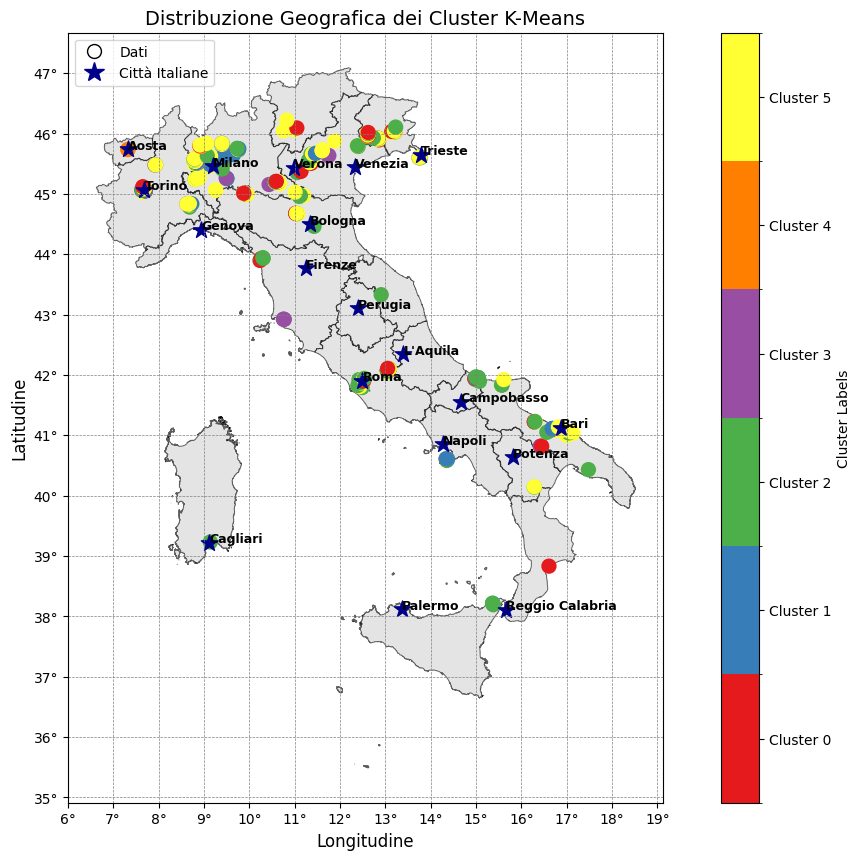

In [45]:
# Non vengono considerati eventuali punti fuori dai confini
all_data_kmeans = all_data_kmeans[
    (all_data_kmeans['latitude'] >= 35) & (all_data_kmeans['latitude'] <= 47) &
    (all_data_kmeans['longitude'] >= 6) & (all_data_kmeans['longitude'] <= 19)
]

fig, ax = plt.subplots(figsize=(15, 10))

ripartizioni_geografiche.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.6, linewidth=0.7)
scatter = ax.scatter(most_frequent_clusters_kmeans['longitude'], most_frequent_clusters_kmeans['latitude'], c=most_frequent_clusters_kmeans['cluster'], cmap=cmap, s=100, label="Dati")

ax.scatter(citta_italiane['longitude'], citta_italiane['latitude'], c="darkblue", marker="*", s=150, label="Città Italiane")

for i, row in citta_italiane.iterrows():
    ax.text(
        row['longitude'], row['latitude'], row['citta'],
        fontsize=9, color="black", weight="bold", ha="left"
    )

ax.set_xticks(range(6, 20, 1))
ax.set_yticks(range(35, 48, 1))
ax.set_xticklabels([f"{i}°" for i in range(6, 20, 1)], fontsize=10)
ax.set_yticklabels([f"{i}°" for i in range(35, 48, 1)], fontsize=10)

ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

ax.set_title(f"Distribuzione Geografica dei Cluster K-Means", fontsize=14)
ax.set_xlabel("Longitudine", fontsize=12)
ax.set_ylabel("Latitudine", fontsize=12)

bounds = np.arange(n_clusters_kmeans + 1)
norm = BoundaryNorm(bounds, cmap.N)

cbar = plt.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    ticks=np.arange(n_clusters_kmeans) + 0.5,
    label="Cluster Labels"
)
cbar.ax.set_yticklabels([f'Cluster {i}' for i in range(n_clusters_kmeans)])

plt.legend(handles=[empty_circle, star], loc="upper left")


Istogramma dispositivi appartenenti a ciascun cluster K-Means

Text(0, 0.5, 'Numero di Dispositivi')

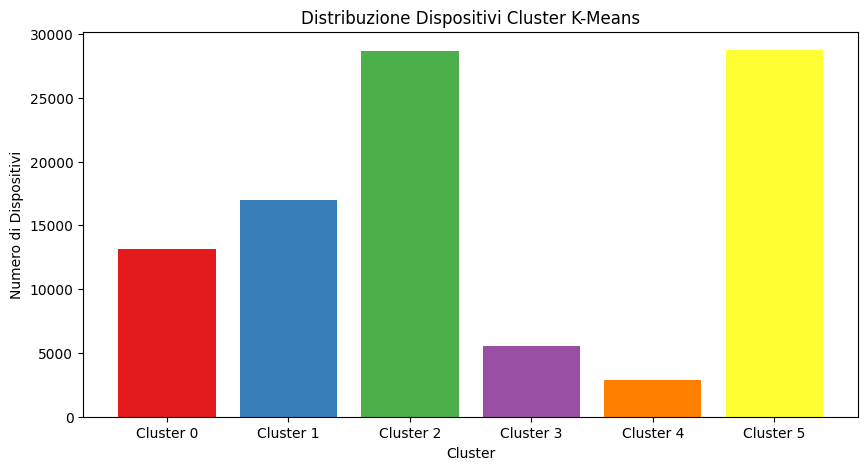

In [46]:
plt.figure(figsize=(10,5))

cluster_counts_kmeans = [np.sum(labels_kmeans == i) for i in range(n_clusters_kmeans)]
cluster_names_kmeans = [f"Cluster {i}" for i in range(n_clusters_kmeans)]

plt.title("Distribuzione Dispositivi Cluster K-Means")
plt.bar(cluster_names_kmeans,cluster_counts_kmeans, color=colors)
plt.xlabel("Cluster")
plt.ylabel("Numero di Dispositivi")



### Agglomerative Clustering

In [47]:
data_list = []
for idx, device_id in enumerate(sensor_id):
    series_data_agg = series[device_id].copy()
    series_data_agg['cluster'] = labels_agg[idx]
    series_data_agg['latitude'] = series_data_agg['latitude'].mean()
    series_data_agg['longitude'] = series_data_agg['longitude'].mean()
    data_list.append(series_data_agg[['latitude', 'longitude', 'cluster']])

all_data_agg = pd.concat(data_list, axis=0)
all_data_agg.reset_index(drop=True, inplace=True)

Distribuzione Geografica Cluster Agglomerative Clustering

In [48]:
colors = sea.color_palette('Set1', n_clusters_agg)
cmap = ListedColormap(colors)

In [49]:
# Raggruppa per latitudine e longitudine e trova il cluster più frequente per ogni coppia
most_frequent_clusters_agg = (all_data_agg.groupby(['latitude', 'longitude'])['cluster'].agg(lambda x: x.value_counts().idxmax()).reset_index())
most_frequent_clusters_agg.columns = ['latitude', 'longitude', 'cluster']

most_frequent_clusters_agg

latitude  longitude  cluster
0    38.193261  15.380132        4
1    38.215255  15.369016        2
2    38.215255  15.369016        0
3    38.217912  15.364215        4
4    38.833027  16.608603        0
..         ...        ...      ...
307  46.061740  10.988034        4
308  46.079153  11.001846        0
309  46.093693  11.048647        1
310  46.108362  13.227983        4
311  46.222686  10.827135        4

[312 rows x 3 columns]

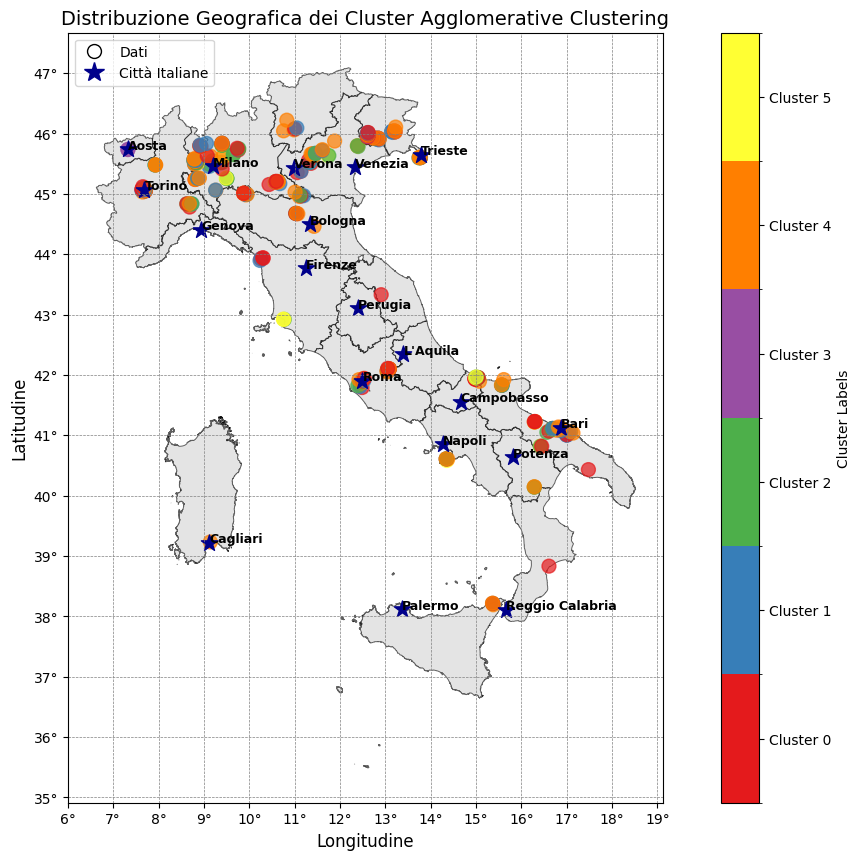

In [50]:
all_data_agg = all_data_agg[
    (all_data_agg['latitude'] >= 35) & (all_data_agg['latitude'] <= 47) &
    (all_data_agg['longitude'] >= 6) & (all_data_agg['longitude'] <= 19)
]

fig, ax = plt.subplots(figsize=(15, 10))

ripartizioni_geografiche.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.6, linewidth=0.7)
scatter = ax.scatter(most_frequent_clusters_agg['longitude'], most_frequent_clusters_agg['latitude'], c=most_frequent_clusters_agg['cluster'], cmap=cmap, alpha=0.7, s=100, label="Dati")

ax.scatter(citta_italiane['longitude'], citta_italiane['latitude'], c="darkblue", marker="*", s=150, label="Città Italiane")

for i, row in citta_italiane.iterrows():
    ax.text(
        row['longitude'], row['latitude'], row['citta'],
        fontsize=9, color="black", weight="bold", ha="left"
    )

ax.set_xticks(range(6, 20, 1))
ax.set_yticks(range(35, 48, 1))
ax.set_xticklabels([f"{i}°" for i in range(6, 20, 1)], fontsize=10)
ax.set_yticklabels([f"{i}°" for i in range(35, 48, 1)], fontsize=10)

ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

ax.set_title(f"Distribuzione Geografica dei Cluster Agglomerative Clustering", fontsize=14)
ax.set_xlabel("Longitudine", fontsize=12)
ax.set_ylabel("Latitudine", fontsize=12)

bounds = np.arange(n_clusters_agg + 1)
norm = BoundaryNorm(bounds, cmap.N)

cbar = plt.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    ticks=np.arange(n_clusters_agg) + 0.5,
    label="Cluster Labels"
)
cbar.ax.set_yticklabels([f'Cluster {i}' for i in range(n_clusters_agg)])

plt.legend(handles=[empty_circle, star], loc="upper left")

Istogramma dispositivi appartenenti a ciascun cluster Agglomerative Clustering

Text(0, 0.5, 'Numero di Dispositivi')

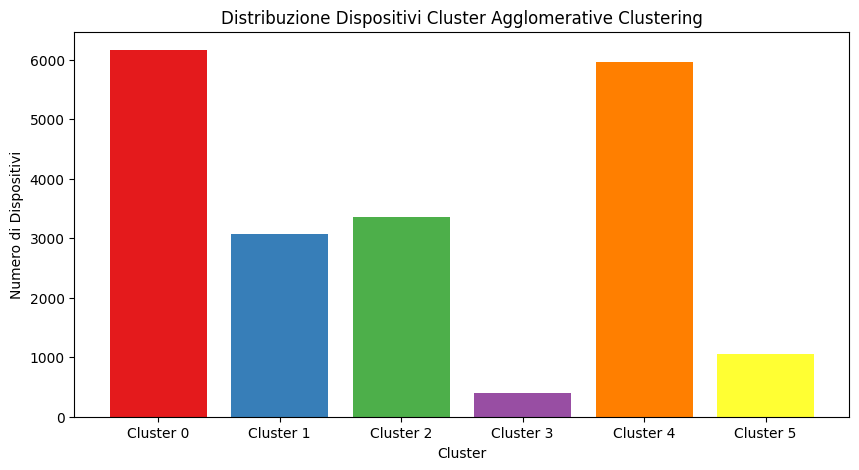

In [51]:
plt.figure(figsize=(10,5))

cluster_counts_agg = [np.sum(labels_agg == i) for i in range(n_clusters_agg)]
cluster_names_agg = [f"Cluster {i}" for i in range(n_clusters_agg)]

plt.title("Distribuzione Dispositivi Cluster Agglomerative Clustering")
plt.bar(cluster_names_agg, cluster_counts_agg, color=colors)
plt.xlabel("Cluster")
plt.ylabel("Numero di Dispositivi")

### Spectral Clustering

In [52]:
data_list = []
for idx, device_id in enumerate(sensor_id):
    series_data_spec = series[device_id].copy()
    series_data_spec['cluster'] = labels_spec[idx]
    series_data_spec['latitude'] = series_data_spec['latitude'].mean()
    series_data_spec['longitude'] = series_data_spec['longitude'].mean()
    data_list.append(series_data_spec[['latitude', 'longitude', 'cluster']])

all_data_spec = pd.concat(data_list, axis=0)
all_data_spec.reset_index(drop=True, inplace=True)

Distribuzione Geografica Cluster Spectral Clustering

In [53]:
colors = sea.color_palette('Set1', n_clusters_spec)
cmap = ListedColormap(colors)

In [54]:
# Raggruppa per latitudine e longitudine e trova il cluster più frequente per ogni coppia
most_frequent_clusters_spec = (all_data_spec.groupby(['latitude', 'longitude'])['cluster'].agg(lambda x: x.value_counts().idxmax()).reset_index())
most_frequent_clusters_spec.columns = ['latitude', 'longitude', 'cluster']

most_frequent_clusters_spec

latitude  longitude  cluster
0    38.193261  15.380132        0
1    38.215255  15.369016        4
2    38.215255  15.369016        0
3    38.217912  15.364215        0
4    38.833027  16.608603        1
..         ...        ...      ...
307  46.061740  10.988034        1
308  46.079153  11.001846        1
309  46.093693  11.048647        1
310  46.108362  13.227983        0
311  46.222686  10.827135        5

[312 rows x 3 columns]

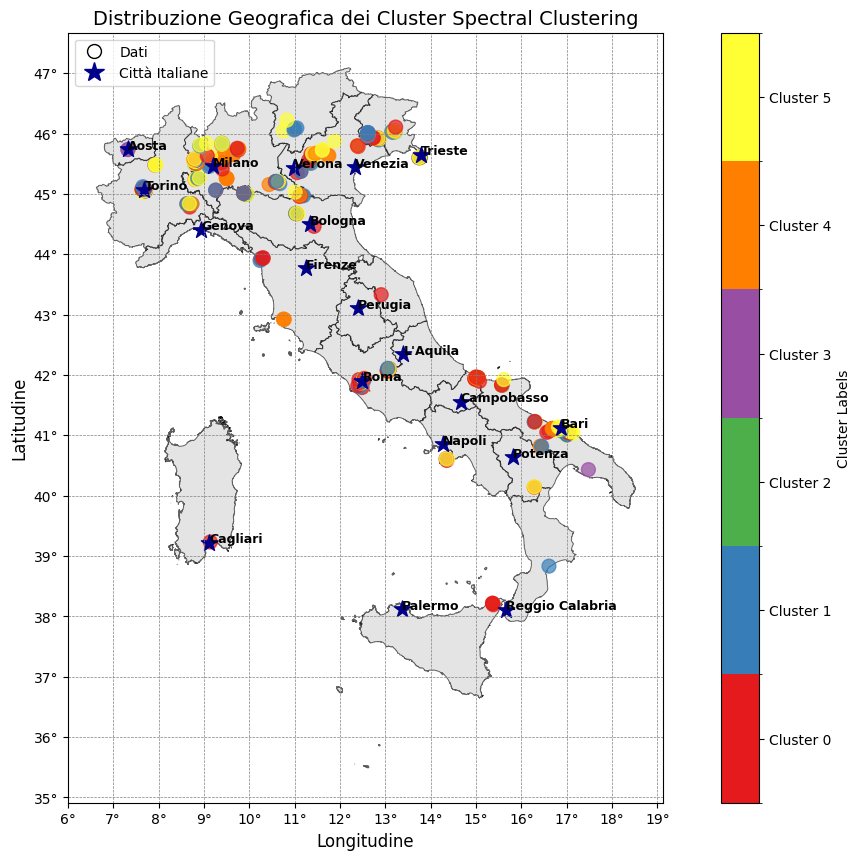

In [55]:
all_data_spec = all_data_spec[
    (all_data_spec['latitude'] >= 35) & (all_data_spec['latitude'] <= 47) &
    (all_data_spec['longitude'] >= 6) & (all_data_spec['longitude'] <= 19)
]

fig, ax = plt.subplots(figsize=(15, 10))

ripartizioni_geografiche.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.6, linewidth=0.7)
scatter = ax.scatter(most_frequent_clusters_spec['longitude'], most_frequent_clusters_spec['latitude'], c=most_frequent_clusters_spec['cluster'], cmap=cmap, alpha=0.7, s=100, label="Dati")

ax.scatter(citta_italiane['longitude'], citta_italiane['latitude'], c="darkblue", marker="*", s=150, label="Città Italiane")

for i, row in citta_italiane.iterrows():
    ax.text(
        row['longitude'], row['latitude'], row['citta'],
        fontsize=9, color="black", weight="bold", ha="left"
    )

ax.set_xticks(range(6, 20, 1))
ax.set_yticks(range(35, 48, 1))
ax.set_xticklabels([f"{i}°" for i in range(6, 20, 1)], fontsize=10)
ax.set_yticklabels([f"{i}°" for i in range(35, 48, 1)], fontsize=10)

ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

ax.set_title(f"Distribuzione Geografica dei Cluster Spectral Clustering", fontsize=14)
ax.set_xlabel("Longitudine", fontsize=12)
ax.set_ylabel("Latitudine", fontsize=12)

bounds = np.arange(n_clusters_spec + 1)
norm = BoundaryNorm(bounds, cmap.N)

cbar = plt.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    ticks=np.arange(n_clusters_spec) + 0.5,
    label="Cluster Labels"
)
cbar.ax.set_yticklabels([f'Cluster {i}' for i in range(n_clusters_spec)])

plt.legend(handles=[empty_circle, star], loc="upper left")

Istogramma dispositivi appartenenti a ciascun cluster Spectral Clustering

Text(0, 0.5, 'Numero di Dispositivi')

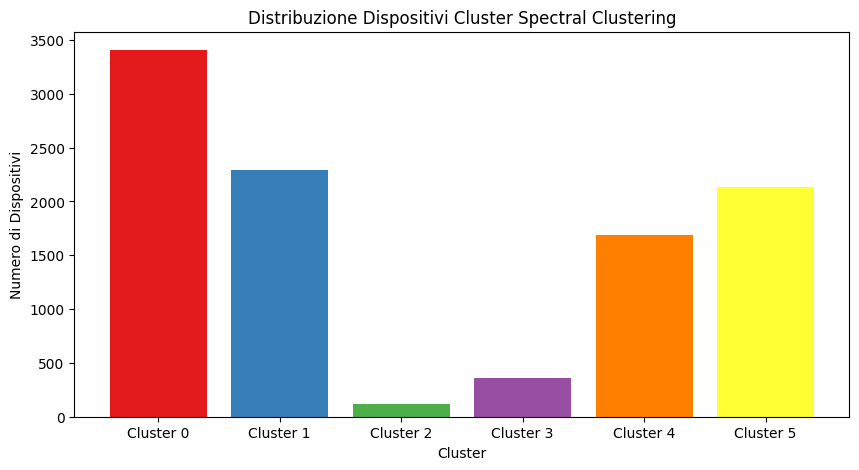

In [56]:
plt.figure(figsize=(10,5))

cluster_counts_spec = [np.sum(labels_spec == i) for i in range(n_clusters_spec)]
cluster_names_spec = [f"Cluster {i}" for i in range(n_clusters_spec)]

plt.title("Distribuzione Dispositivi Cluster Spectral Clustering")
plt.bar(cluster_names_spec,cluster_counts_spec, color=colors)
plt.xlabel("Cluster")
plt.ylabel("Numero di Dispositivi")

## Cluster Analysis

In [57]:
series_analysis

{'ari-1009':                         device_id   latitude  longitude  pm2p5_sps30_ug_m3  \
 created_at_utc_original                                                      
 2023-04-04               ari-1009  45.456144   9.115223              11.13   
 2023-04-05               ari-1009  45.456144   9.115223               6.30   
 2023-04-06               ari-1009  45.456144   9.115223               9.77   
 2023-04-07               ari-1009  45.456144   9.115223              17.82   
 2023-04-08               ari-1009  45.456144   9.115223              33.23   
 ...                           ...        ...        ...                ...   
 2024-06-26               ari-1009  45.456144   9.115223              14.70   
 2024-06-27               ari-1009  45.456144   9.115223              15.16   
 2024-06-28               ari-1009  45.456144   9.115223               5.70   
 2024-06-29               ari-1009  45.456144   9.115223              10.56   
 2024-06-30               ari-1009  45.4

In [58]:
series_analysis_df = pd.concat(series_analysis.values(), keys=series_analysis.keys())

# Resetta l'indice per avere una struttura migliore
series_analysis_df.reset_index(level=0, inplace=True)
series_analysis_df.rename(columns={'level_0': 'device_id'}, inplace=True)
series_analysis_df.reset_index(inplace=True)
series_analysis_df = series_analysis_df.loc[:, ~series_analysis_df.columns.duplicated()]


print(series_analysis_df.head())

  created_at_utc_original device_id   latitude  longitude  pm2p5_sps30_ug_m3  \
0              2023-04-04  ari-1009  45.456144   9.115223              11.13   
1              2023-04-05  ari-1009  45.456144   9.115223               6.30   
2              2023-04-06  ari-1009  45.456144   9.115223               9.77   
3              2023-04-07  ari-1009  45.456144   9.115223              17.82   
4              2023-04-08  ari-1009  45.456144   9.115223              33.23   

   wind_speed_owm_m_s  rh_percentage  temperature_celsius  pressure_pa  \
0                2.06           36.0                12.24       1013.0   
1                3.09           72.0                 6.32       1018.0   
2                2.24           49.0                 5.94       1019.0   
3                1.54           62.0                 8.32       1016.0   
4                0.51           84.0                 7.78       1016.0   

   rain_last_1h_mm  
0              0.0  
1              0.0  
2          

Selezione Modello Analisi Cluster: (K-Means)

In [59]:
model_name="K-Means"
n_clusters = n_clusters_kmeans
series_analysis_df[f"Cluster {model_name}"] = labels_kmeans

# Configurazione della Mappa Colori per Visualizzazione
colors = sea.color_palette('Set1', n_clusters)
cmap = ListedColormap(colors)

Analisi dei Dispositivi per Cluster e Calcolo delle Medie delle Feature

In [60]:
# Raggruppa per il cluster e calcola la media per ciascun gruppo
cluster_averages = series_analysis_df.groupby('Cluster K-Means')[features].mean().reset_index()

print("Medie:")
print(cluster_averages)


Medie:
   Cluster K-Means  pm2p5_sps30_ug_m3  wind_speed_owm_m_s  rh_percentage  \
0                0          13.785069            4.383833      74.175202   
1                1          31.999862            1.812649      72.525511   
2                2          28.532854            1.751827      86.121372   
3                3         191.767700            1.583369      85.340510   
4                4          25.498686            2.793632      87.447051   
5                5          15.962824            1.893369      71.058909   

   temperature_celsius  pressure_pa  rain_last_1h_mm  
0            13.380460  1009.787685         0.046209  
1             6.903266  1023.634202         0.004481  
2            11.376867  1011.060214         0.027365  
3             8.569316  1020.049874         0.011215  
4            12.491080  1007.293549         1.504088  
5            19.651105  1015.876544         0.007256  


Visualizzazione Medie Feature per Cluster

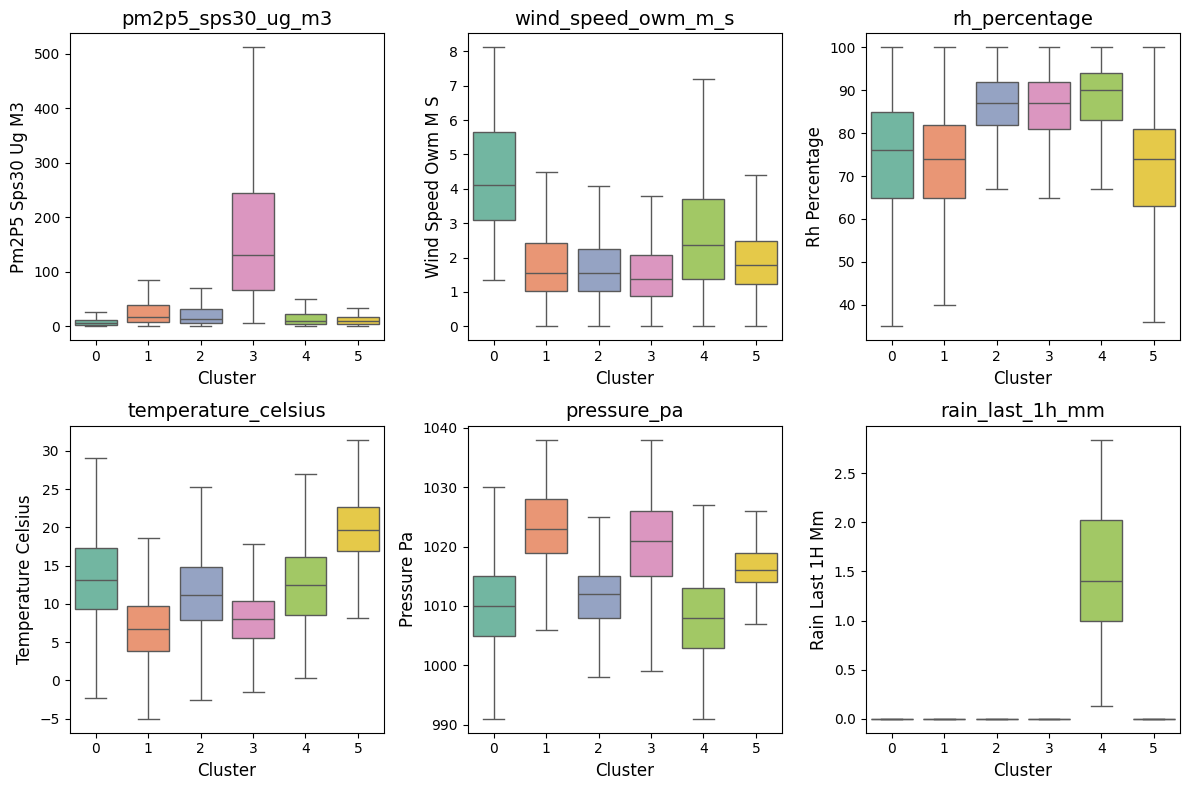

In [61]:
cluster_averages_df = pd.DataFrame(cluster_averages)

plt.figure(figsize = (12,8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    cluster_avarages_plot=sea.boxplot(x='Cluster K-Means', y=feature, data=series_analysis_df, palette="Set2", showfliers=False)

    plt.title(f"{feature}", fontsize=14)
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel(f"{feature.replace('_', ' ').title()}", fontsize=12)

plt.tight_layout()

Il grafico mostra i boxplot delle variabili principali (PM2.5, velocità del vento, umidità relativa, temperatura, pressione atmosferica e pioggia) suddivise per cluster.

1. PM2.5 (pm2p5_sps30_ug_m3)
Il Cluster 3 presenta valori di PM2.5 significativamente più alti rispetto agli altri cluster, con una grande variabilità (outlier molto alti).
Gli altri cluster (0, 1, 2, 4, 5) mostrano valori di PM2.5 relativamente bassi e simili tra loro, con una variabilità vicine allo zero.

- Cluster 0 e vento:
Il Cluster 0 è caratterizzato da velocità del vento più elevate, il che potrebbe favorire la dispersione del particolato.
- Cluster 3 e PM2.5:
Il Cluster 3 è chiaramente associato a livelli elevati di PM2.5, suggerendo che rappresenti aree o periodi con alta concentrazione di particolato.
- Cluster 4 e pioggia (umidità):
Il Cluster 4 è caratterizzato da alta umidità, elevata pressione atmosferica e presenza di pioggia, indicando condizioni meteorologiche specifiche.
- Cluster 5 e temperatura:
Il Cluster 5 è associato a temperature più elevate e umidità più bassa, segnalando condizioni più calde e secche.

Analizzando insieme i due grafici (boxplot per cluster e matrice di correlazione), emergono i seguenti punti chiave:

- Cluster 0 e vento:
La velocità del vento ha una correlazione negativa con il PM2.5 (-0.15), indicando che il vento contribuisce a disperdere il particolato.
- Cluster 3 e PM2.5:
La concentrazione di PM2.5 ha una correlazione positiva con l'umidità relativa (rh_percentage, 0.21) e una correlazione negativa con la temperatura (temperature_celsius, -0.24). Questo suggerisce che il Cluster 3 potrebbe essere associato a condizioni di alta umidità e bassa temperatura, che favoriscono l'accumulo di particolato.
- Cluster 4 e pioggia:
L'umidità ha una correlazione positiva con il PM2.5 (0.21) e una correlazione negativa con la temperatura (-0.45), suggerendo che condizioni di alta umidità siano associate a un aumento dei livelli di particolato.
Tuttavia, considerando che i livelli di particolato sono bassi, è possibile che uno tra temperatura o umidità presenti un valore anomalo, influenzando la correlazione osservata.
Allo stesso tempo, la pressione atmosferica e la pioggia non mostrano correlazioni significative con le altre variabili, suggerendo che non abbiano un impatto diretto sui livelli di PM2.5.
- Cluster 5 e temperatura:
La temperatura ha una correlazione negativa con il PM2.5 (temperature_celsius, -0.24), suggerendo che temperature più alte sono associate a una migliore dispersione del particolato e a condizioni più secche.

Assegnazione dati sensori alle città italiane

In [62]:
#Soglia di distanza in gradi (1 grado = 111 km)
threshold_distance = 1

# Creazione del KDTree basato sulle coordinate geografiche (latitude e longitude) dei sensori.
kdtree_model = KDTree(series_analysis_df[['latitude', 'longitude']])

citta_italiane_istanze = []
clusters_per_citta = []
# Iterazione sulle città nel DataFrame
for _, row in citta_italiane.iterrows():
    latitude, longitude = row['latitude'], row['longitude']

    # Ricerca dei sensori vicini alla città corrente entro la soglia di distanza
    indices = kdtree_model.query_ball_point([latitude, longitude], threshold_distance)

    # Se ci sono punti vicini
    if indices:
        city_clusters = series_analysis_df.iloc[indices]['Cluster K-Means']
        # Determinazione del cluster più comune !!
        most_common_cluster = city_clusters.value_counts().idxmax()

        nearby_instances = series_analysis_df.iloc[indices]
        # Per ogni istanza vicina, creo una istanza nel nuovo DataFrame
        for _, instance in nearby_instances.iterrows():
            citta_italiane_istanze.append({
                'citta': row['citta'],
                'city_latitude': latitude,
                'city_longitude': longitude,
                'device_id': instance['device_id'],
                'created_at_utc_original': instance['created_at_utc_original'],
                'instance_longitude': instance['longitude'],
                'instance_latitude': instance['latitude'],
                'pm2p5_sps30_ug_m3': instance['pm2p5_sps30_ug_m3'],
                'wind_speed_owm_m_s': instance['wind_speed_owm_m_s'],
                'rh_percentage': instance['rh_percentage'],
                'temperature_celsius': instance['temperature_celsius'],
                'pressure_pa': instance['pressure_pa'],
                'rain_last_1h_mm': instance['rain_last_1h_mm'],
                'cluster': instance['Cluster K-Means']
            })
    else:
        most_common_cluster = None
        print(f"Nessun dato vicino a {row['citta']}")

    clusters_per_citta.append(most_common_cluster)

citta_italiane['Cluster'] = clusters_per_citta
citta_italiane

Nessun dato vicino a Palermo


citta  latitude  longitude  popolazione  altitudine  Cluster
0            Milano   45.4642     9.1900      1378689         120      5.0
1              Roma   41.9028    12.4964      2872800          21      2.0
2            Napoli   40.8518    14.2681       959574          17      5.0
3            Torino   45.0703     7.6869       870456         239      5.0
4           Firenze   43.7696    11.2558       367150          50      5.0
5          Cagliari   39.2238     9.1217       154106           4      5.0
6           Venezia   45.4408    12.3358       261905           1      2.0
7           Bologna   44.4949    11.3420       394843          54      5.0
8            Genova   44.4056     8.9443       583601          20      5.0
9           Palermo   38.1157    13.3615       663401          14      NaN
10             Bari   41.1259    16.8698       323370           5      2.0
11           Verona   45.4384    10.9916       258031          59      2.0
12          Trieste   45.6495    13.7768       201187           2      2.0
13  Reggio Calabria   38.1117    15.6613       180369          31      2.0
14          Perugia   43.1107    12.3890       165683         493      2.0
15          Potenza   40.6404    15.8056        66393         819      5.0
16         L'Aquila   42.3498    13.3995        69478         714      2.0
17       Campobasso   41.5595    14.6593        48887         701      2.0
18            Aosta   45.7370     7.3201        34062         583      5.0

In [63]:
citta_italiane_istanze_df = pd.DataFrame(citta_italiane_istanze)

citta_italiane_istanze_df

citta  city_latitude  city_longitude device_id  \
0       Milano        45.4642          9.1900  ari-2073   
1       Milano        45.4642          9.1900  ari-2414   
2       Milano        45.4642          9.1900  ari-2073   
3       Milano        45.4642          9.1900  ari-2073   
4       Milano        45.4642          9.1900  ari-2073   
...        ...            ...             ...       ...   
131128   Aosta        45.7370          7.3201  ari-2452   
131129   Aosta        45.7370          7.3201  ari-2452   
131130   Aosta        45.7370          7.3201  ari-2452   
131131   Aosta        45.7370          7.3201  ari-2452   
131132   Aosta        45.7370          7.3201  ari-2452   

       created_at_utc_original  instance_longitude  instance_latitude  \
0                   2023-07-26            8.622787          44.835936   
1                   2024-04-24            8.622787          44.835936   
2                   2023-05-05            8.622787          44.835936   
3                   2023-05-04            8.622787          44.835936   
4                   2023-05-03            8.622787          44.835936   
...                        ...                 ...                ...   
131128              2024-04-18            7.933471          45.481434   
131129              2024-04-19            7.933471          45.481434   
131130              2024-04-20            7.933471          45.481434   
131131              2024-04-21            7.933471          45.481434   
131132              2024-04-22            7.933471          45.481434   

        pm2p5_sps30_ug_m3  wind_speed_owm_m_s  rh_percentage  \
0                   12.47                1.35           75.0   
1                   17.73                0.17           97.0   
2                   10.75                1.45           29.0   
3                    5.78                0.82           36.0   
4                    5.86                2.39           91.0   
...                   ...                 ...            ...   
131128               3.09                3.72           52.0   
131129               0.55                4.04           81.0   
131130               1.49                2.74           72.0   
131131               0.61                4.09           53.0   
131132               2.94                2.80           74.0   

        temperature_celsius  pressure_pa  rain_last_1h_mm  cluster  
0                     22.70       1007.0              0.0        5  
1                      6.52       1009.0              0.0        2  
2                     17.18       1020.0              0.0        5  
3                     15.25       1021.0              0.0        5  
4                     13.50       1019.0              0.0        0  
...                     ...          ...              ...      ...  
131128                 7.73       1008.0              0.0        0  
131129                 2.72       1019.0              0.0        0  
131130                 8.33       1009.0              0.0        0  
131131                 6.51       1017.0              0.0        0  
131132                 6.80       1015.0              0.0        0  

[131133 rows x 14 columns]

Selezione Città

In [64]:
# Filtra le istanze per città
città="Bologna"
data_city = citta_italiane_istanze_df[citta_italiane_istanze_df['citta'] == città]


Visualizzazione distribuzione geografica, colorato per cluster

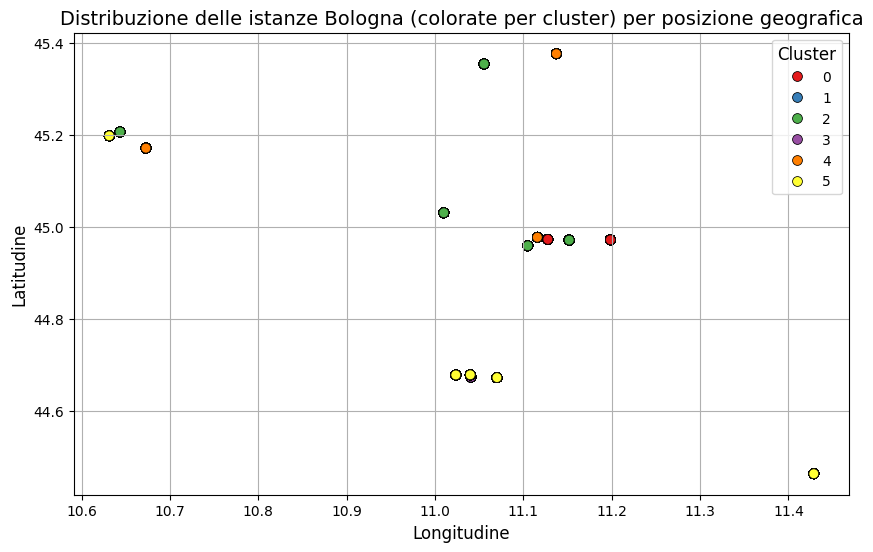

In [65]:
# Raggruppa per posizione geografica e seleziona il valore cluster più frequente per ogni posizione
data_city_mode = (
    data_city.groupby(['instance_latitude', 'instance_longitude'])
    .apply(lambda x: x[x['cluster'] == x['cluster'].mode().iloc[0]].iloc[0])
    .reset_index(drop=True)
)

plt.figure(figsize=(10, 6))
sea.scatterplot(
    data=data_city,
    x='instance_longitude',
    y='instance_latitude',
    hue='cluster',
    palette=cmap,
    s=50,
    edgecolor='black'
)

plt.title(f"Distribuzione delle istanze {città} (colorate per cluster) per posizione geografica", fontsize=14)
plt.xlabel('Longitudine', fontsize=12)
plt.ylabel('Latitudine', fontsize=12)
plt.legend(title='Cluster', fontsize=10, title_fontsize=12)
plt.grid(True)

Visualizzazione distribuzione temporale, colorato per cluster

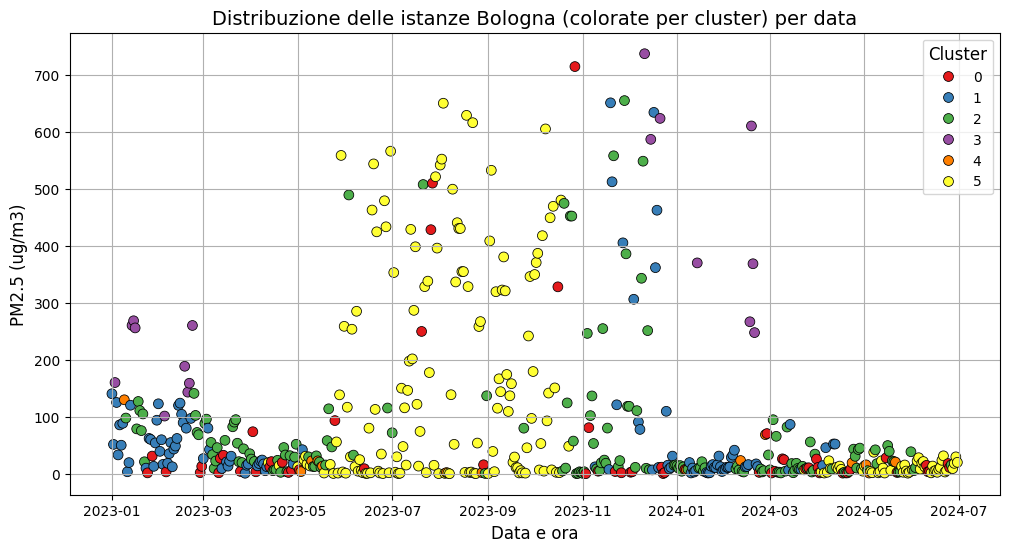

In [66]:
# Raggruppa per data e seleziona il valore cluster per ogni data
data_city_mode = (
    data_city.groupby('created_at_utc_original')
    .apply(lambda x: x[x['cluster'] == x['cluster'].mode().iloc[0]].iloc[0])
    .reset_index(drop=True)
)

plt.figure(figsize=(12, 6))
sea.scatterplot(
    data=data_city_mode,
    x='created_at_utc_original',
    y='pm2p5_sps30_ug_m3',
    hue='cluster',
    palette=cmap,
    s=50,
    edgecolor='black'
)

plt.title(f"Distribuzione delle istanze {città} (colorate per cluster) per data", fontsize=14)
plt.xlabel('Data e ora', fontsize=12)
plt.ylabel('PM2.5 (ug/m3)', fontsize=12)
plt.legend(title='Cluster', fontsize=10, title_fontsize=12)
plt.grid(True)

Statistiche distribuzione cluster per città

In [67]:
cluster_distribution = citta_italiane_istanze_df.groupby(['citta', 'cluster']).size().unstack(fill_value=0)

cluster_distribution

cluster             0     1     2     3    4     5
citta                                             
Aosta             871  1179  2010   390  193  2255
Bari             1599  1727  2869   572  184  2848
Bologna           774  1075  1900   382  191  1949
Cagliari           94   110   160    13    6   164
Campobasso       1178  1269  2176   334  119  1939
Firenze           444   606   989   187   92  1036
Genova            803  1026  1722   392  171  1903
L'Aquila          604   977  1948   174  144  1579
Milano           3422  4514  7329  1664  899  8153
Napoli            242   252   495    92   28   531
Perugia            49    83   169    24   10   118
Potenza           662   787  1256   232   75  1315
Reggio Calabria   148   165   280    41   18   252
Roma             1075  1427  2776   286  219  2470
Torino            941  1255  2130   429  204  2411
Trieste           966  1284  2427   502  291  2300
Venezia          1593  2383  3639   782  487  3555
Verona           2115  2980  5035  1076  616  4847

In [68]:
cluster_percentages = cluster_distribution.div(cluster_distribution.sum(axis=1), axis=0) * 100

cluster_distribution['dominant_cluster'] = cluster_distribution.idxmax(axis=1)
cluster_distribution['total_instances'] = cluster_distribution.sum(axis=1)
cluster_distribution['dominant_percentage'] = cluster_percentages.max(axis=1).round(2)

# Ordino per percentuale dominante decrescente
cluster_distribution = cluster_distribution.sort_values('dominant_percentage', ascending=False)

cluster_distribution

cluster             0     1     2     3    4     5  dominant_cluster  \
citta                                                                  
Perugia            49    83   169    24   10   118                 2   
L'Aquila          604   977  1948   174  144  1579                 2   
Roma             1075  1427  2776   286  219  2470                 2   
Torino            941  1255  2130   429  204  2411                 5   
Aosta             871  1179  2010   390  193  2255                 5   
Napoli            242   252   495    92   28   531                 5   
Genova            803  1026  1722   392  171  1903                 5   
Milano           3422  4514  7329  1664  899  8153                 5   
Trieste           966  1284  2427   502  291  2300                 2   
Bologna           774  1075  1900   382  191  1949                 5   
Campobasso       1178  1269  2176   334  119  1939                 2   
Reggio Calabria   148   165   280    41   18   252                 2   
Firenze           444   606   989   187   92  1036                 5   
Potenza           662   787  1256   232   75  1315                 5   
Verona           2115  2980  5035  1076  616  4847                 2   
Cagliari           94   110   160    13    6   164                 5   
Bari             1599  1727  2869   572  184  2848                 2   
Venezia          1593  2383  3639   782  487  3555                 2   

cluster          total_instances  dominant_percentage  
citta                                                  
Perugia                      455                37.31  
L'Aquila                    5428                35.90  
Roma                        8255                33.64  
Torino                      7375                32.71  
Aosta                       6903                32.69  
Napoli                      1645                32.38  
Genova                      6022                31.63  
Milano                     25986                31.38  
Trieste                     7772                31.24  
Bologna                     6276                31.08  
Campobasso                  7017                31.02  
Reggio Calabria              906                30.97  
Firenze                     3359                30.89  
Potenza                     4332                30.39  
Verona                     16671                30.21  
Cagliari                     552                29.98  
Bari                        9801                29.28  
Venezia                    12441                29.25

Visualizzazione geografica dei cluster associati alle città

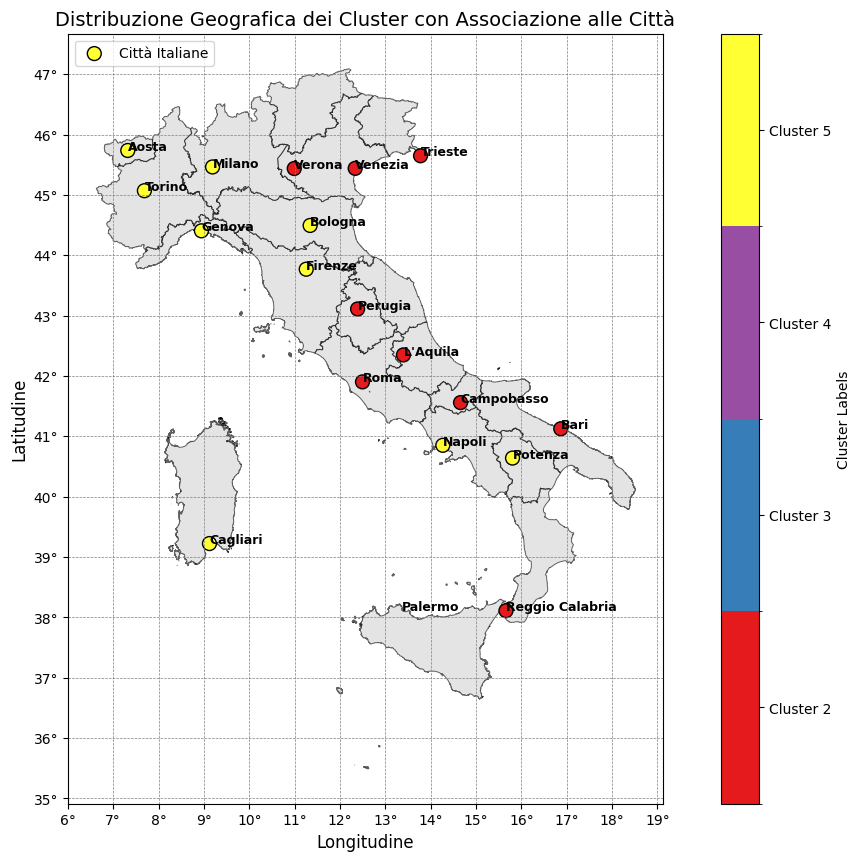

In [69]:
fig, ax = plt.subplots(figsize=(15, 10))

ripartizioni_geografiche.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.6, linewidth=0.7)
ax.scatter(citta_italiane['longitude'], citta_italiane['latitude'],
           c=citta_italiane['Cluster'], cmap=cmap, marker="o", s=100, edgecolor="black", label="Città Italiane")

for i, row in citta_italiane.iterrows():
    ax.text(row['longitude'], row['latitude'], row['citta'], fontsize=9, color="black", weight="bold", ha="left")

ax.set_xticks(range(6, 20, 1))
ax.set_yticks(range(35, 48, 1))
ax.set_xticklabels([f"{i}°" for i in range(6, 20, 1)], fontsize=10)
ax.set_yticklabels([f"{i}°" for i in range(35, 48, 1)], fontsize=10)

ax.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)

ax.set_title("Distribuzione Geografica dei Cluster con Associazione alle Città", fontsize=14)
ax.set_xlabel("Longitudine", fontsize=12)
ax.set_ylabel("Latitudine", fontsize=12)

unique_clusters = sorted(citta_italiane['Cluster'].dropna().unique())
bounds = np.arange(min(unique_clusters), max(unique_clusters) + 2)
norm = BoundaryNorm(bounds, cmap.N)

cbar = plt.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    ticks=np.arange(n_clusters) + 0.5,
    label="Cluster Labels"
)
cbar.ax.set_yticklabels([f'Cluster {i}' for i in range(n_clusters)])

plt.legend(loc="upper left")


Analisi della popolazione per cluster

In [70]:
# Calcolo della popolazione totale per ogni cluster
popolazione_per_cluster = citta_italiane.groupby('Cluster')['popolazione'].sum()

popolazione_per_cluster_df = pd.DataFrame(popolazione_per_cluster)

# Aggiunta del valore medio di PM2.5 per cluster in popolazione_per_cluster_df
popolazione_per_cluster_df['pm2p5_sps30_ug_m3'] = popolazione_per_cluster_df.index.map( lambda cluster: cluster_averages.loc[cluster_averages['Cluster K-Means'] == cluster, 'pm2p5_sps30_ug_m3'].values[0])
# Aggiunta del valore medio di PM2.5 per cluster in citta_italiane
citta_italiane['pm2p5_sps30_ug_m3'] = citta_italiane['Cluster'].map( lambda cluster: cluster_averages.loc[cluster_averages['Cluster K-Means'] == cluster, 'pm2p5_sps30_ug_m3'].values[0] if not cluster_averages.loc[cluster_averages['Cluster K-Means'] == cluster].empty else None)

popolazione_per_cluster_df = popolazione_per_cluster_df.reset_index()

print(popolazione_per_cluster_df.sort_index())

   Cluster  popolazione  pm2p5_sps30_ug_m3
0      2.0      4381710          28.532854
1      5.0      4808874          15.962824


Analisi correlazione tra le variabili

Text(0.5, 1.0, 'Matrice di Correlazione tra Variabili delle Città')

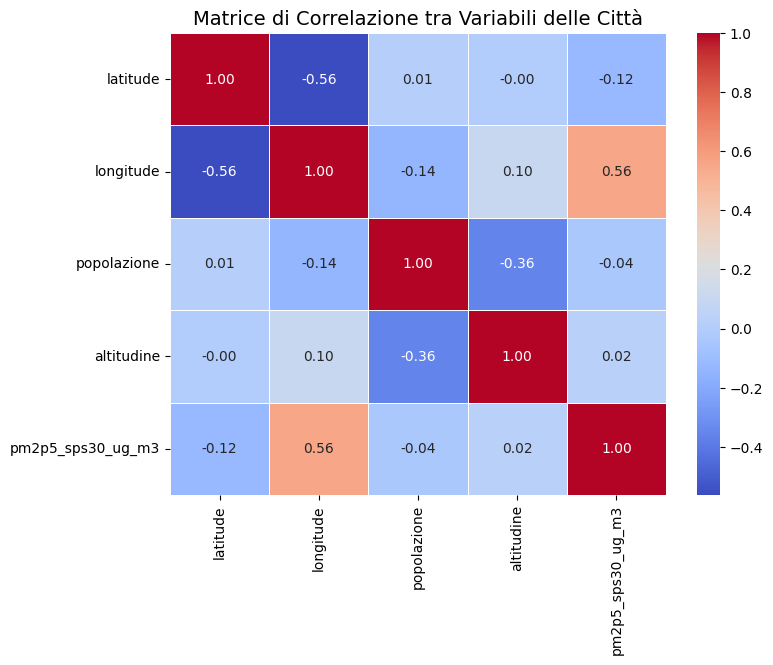

In [71]:
df_correlazione = citta_italiane[['latitude','longitude','popolazione', 'altitudine', 'pm2p5_sps30_ug_m3']]

matrice_correlazione = df_correlazione.corr()

plt.figure(figsize=(8, 6))
sea.heatmap(matrice_correlazione, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice di Correlazione tra Variabili delle Città', fontsize=14)

Analisi della Matrice di Correlazione:

- Longitudine e altitudine (-0,27):
Esiste una correlazione negativa debole tra longitudine e altitudine, suggerendo che le città a longitudini più alte tendono a trovarsi a quote più basse.
- Popolazione e PM2.5 (-0.01):
L'assenza di correlazione tra popolazione e PM2.5 indica che i livelli di particolato non dipendono direttamente dalla densità abitativa, ma potrebbero essere influenzati da altri fattori, come le condizioni climatiche.
- Altitudine e PM2.5 (0.02):
L'altitudine non sembra avere un impatto significativo sui livelli di PM2.5, suggerendo che altri fattori geografici o ambientali sono più rilevanti.

In [72]:
citta_italiane

citta  latitude  longitude  popolazione  altitudine  Cluster  \
0            Milano   45.4642     9.1900      1378689         120      5.0   
1              Roma   41.9028    12.4964      2872800          21      2.0   
2            Napoli   40.8518    14.2681       959574          17      5.0   
3            Torino   45.0703     7.6869       870456         239      5.0   
4           Firenze   43.7696    11.2558       367150          50      5.0   
5          Cagliari   39.2238     9.1217       154106           4      5.0   
6           Venezia   45.4408    12.3358       261905           1      2.0   
7           Bologna   44.4949    11.3420       394843          54      5.0   
8            Genova   44.4056     8.9443       583601          20      5.0   
9           Palermo   38.1157    13.3615       663401          14      NaN   
10             Bari   41.1259    16.8698       323370           5      2.0   
11           Verona   45.4384    10.9916       258031          59      2.0   
12          Trieste   45.6495    13.7768       201187           2      2.0   
13  Reggio Calabria   38.1117    15.6613       180369          31      2.0   
14          Perugia   43.1107    12.3890       165683         493      2.0   
15          Potenza   40.6404    15.8056        66393         819      5.0   
16         L'Aquila   42.3498    13.3995        69478         714      2.0   
17       Campobasso   41.5595    14.6593        48887         701      2.0   
18            Aosta   45.7370     7.3201        34062         583      5.0   

    pm2p5_sps30_ug_m3  
0           15.962824  
1           28.532854  
2           15.962824  
3           15.962824  
4           15.962824  
5           15.962824  
6           28.532854  
7           15.962824  
8           15.962824  
9                 NaN  
10          28.532854  
11          28.532854  
12          28.532854  
13          28.532854  
14          28.532854  
15          15.962824  
16          28.532854  
17          28.532854  
18          15.962824

Analisi Rischio Ambientale, relativo a PM2.5. Valore limite annuale del PM2,5 (25 µg/m³)


In [73]:
# Valore limite annuale per PM2.5
PM2p5_limit = 25

citta_italiane['indice_rischio_cluster'] = citta_italiane['pm2p5_sps30_ug_m3'] / PM2p5_limit
citta_italiane.sort_values('indice_rischio_cluster', ascending=False)

popolazione_per_cluster_df['indice_rischio_cluster'] = popolazione_per_cluster_df['pm2p5_sps30_ug_m3'] / PM2p5_limit
popolazione_per_cluster_df.sort_values('indice_rischio_cluster', ascending=False, inplace=True)
print(popolazione_per_cluster_df)


   Cluster  popolazione  pm2p5_sps30_ug_m3  indice_rischio_cluster
0      2.0      4381710          28.532854                1.141314
1      5.0      4808874          15.962824                0.638513


Visualizzazione Rischio Ambientale

In [74]:
# Filtra i cluster con indice di rischio > 1
high_risk_clusters = popolazione_per_cluster_df[popolazione_per_cluster_df['indice_rischio_cluster'] > 1]['Cluster']

# Filtra le città che appartengono ai cluster ad alto rischio
citta_alto_rischio = citta_italiane[citta_italiane['Cluster'].isin(high_risk_clusters)]
elenco_citta = citta_alto_rischio[['citta','Cluster']].values.tolist()

print("Città nei cluster con indice di rischio > 1:")
for citta, cluster in elenco_citta:
    print(f"Città: {citta}, Cluster: {cluster}")

Città nei cluster con indice di rischio > 1:
Città: Roma, Cluster: 2.0
Città: Venezia, Cluster: 2.0
Città: Bari, Cluster: 2.0
Città: Verona, Cluster: 2.0
Città: Trieste, Cluster: 2.0
Città: Reggio Calabria, Cluster: 2.0
Città: Perugia, Cluster: 2.0
Città: L'Aquila, Cluster: 2.0
Città: Campobasso, Cluster: 2.0


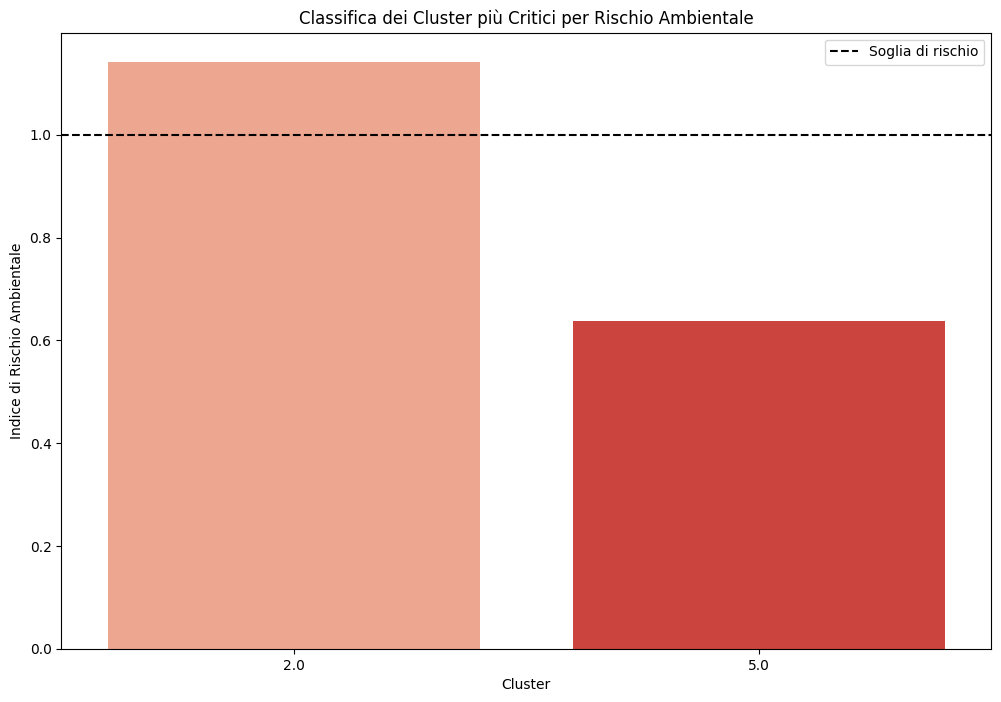

In [75]:
rischio_per_cluster = citta_italiane.groupby('Cluster')['indice_rischio_cluster'].mean().sort_values(ascending=False)

plt.figure(figsize = (12,8))

sea.barplot(x=rischio_per_cluster.index, y=rischio_per_cluster.values, palette="Reds")
plt.axhline(1, color='black', linestyle='--', label='Soglia di rischio', linewidth=1.5)

plt.xlabel("Cluster")
plt.ylabel("Indice di Rischio Ambientale")
plt.title("Classifica dei Cluster più Critici per Rischio Ambientale")
plt.legend()

Il Cluster 2 presenta un indice di rischio ambientale superiore alla soglia di rischio (linea tratteggiata) ed è significativamente più alto rispetto al Cluster 5, che si trova al di sotto della soglia. Questo indica che il Cluster 2 è il più critico in termini di rischio ambientale tra i due.

Analisi di similarità tra città. Individuando città con comportamento simile

In [76]:
# Vado a utilizzare la feature cluster (Avrei potuto usare anche pm2.5 in quanto coincidono!)

# Selezione delle feature
features_città = [
    'altitudine',
    'popolazione',
    'Cluster'
]

# Rimozione valori nulli
citta_italiane.dropna(inplace=True)

# Standardizzazione delle feature
X = citta_italiane[features_città]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [77]:
# Calcolo della similarità del coseno tra le città
similarity_matrix = cosine_similarity(X_scaled)
similarity_df = pd.DataFrame(similarity_matrix, index=citta_italiane['citta'], columns=citta_italiane['citta'])

# Identificazione delle città più simili
similar_cities = {}
for city in citta_italiane['citta']:
    similar_cities[city] = similarity_df[city].drop(city).idxmax()

citta_italiane['Città Simili'] = citta_italiane['citta'].map(similar_cities)

citta_italiane

citta  latitude  longitude  popolazione  altitudine  Cluster  \
0            Milano   45.4642     9.1900      1378689         120      5.0   
1              Roma   41.9028    12.4964      2872800          21      2.0   
2            Napoli   40.8518    14.2681       959574          17      5.0   
3            Torino   45.0703     7.6869       870456         239      5.0   
4           Firenze   43.7696    11.2558       367150          50      5.0   
5          Cagliari   39.2238     9.1217       154106           4      5.0   
6           Venezia   45.4408    12.3358       261905           1      2.0   
7           Bologna   44.4949    11.3420       394843          54      5.0   
8            Genova   44.4056     8.9443       583601          20      5.0   
10             Bari   41.1259    16.8698       323370           5      2.0   
11           Verona   45.4384    10.9916       258031          59      2.0   
12          Trieste   45.6495    13.7768       201187           2      2.0   
13  Reggio Calabria   38.1117    15.6613       180369          31      2.0   
14          Perugia   43.1107    12.3890       165683         493      2.0   
15          Potenza   40.6404    15.8056        66393         819      5.0   
16         L'Aquila   42.3498    13.3995        69478         714      2.0   
17       Campobasso   41.5595    14.6593        48887         701      2.0   
18            Aosta   45.7370     7.3201        34062         583      5.0   

    pm2p5_sps30_ug_m3  indice_rischio_cluster     Città Simili  
0           15.962824                0.638513           Napoli  
1           28.532854                1.141314           Milano  
2           15.962824                0.638513           Genova  
3           15.962824                0.638513           Milano  
4           15.962824                0.638513          Bologna  
5           15.962824                0.638513          Firenze  
6           28.532854                1.141314          Trieste  
7           15.962824                0.638513          Firenze  
8           15.962824                0.638513          Bologna  
10          28.532854                1.141314          Venezia  
11          28.532854                1.141314  Reggio Calabria  
12          28.532854                1.141314          Venezia  
13          28.532854                1.141314          Trieste  
14          28.532854                1.141314       Campobasso  
15          15.962824                0.638513            Aosta  
16          28.532854                1.141314       Campobasso  
17          28.532854                1.141314         L'Aquila  
18          15.962824                0.638513          Potenza

In [78]:
# Creazione Csv
#citta_italiane.to_csv('Statistiche_Città_Italiane.csv', index=False)
#cluster_distribution.to_csv('Distribuzione_Cluster.csv', index=False)
#cluster_percentages.to_csv('Distribuzione_Cluster_Percentuale.csv', index=False)
#citta_alto_rischio.to_csv('Città_Cluster_Alto_Rischio.csv', index=False)

              citta  latitude  longitude  popolazione  altitudine  Cluster  \
0            Milano   45.4642     9.1900      1378689         120      5.0   
1              Roma   41.9028    12.4964      2872800          21      2.0   
2            Napoli   40.8518    14.2681       959574          17      5.0   
3            Torino   45.0703     7.6869       870456         239      5.0   
4           Firenze   43.7696    11.2558       367150          50      5.0   
5          Cagliari   39.2238     9.1217       154106           4      5.0   
6           Venezia   45.4408    12.3358       261905           1      2.0   
7           Bologna   44.4949    11.3420       394843          54      5.0   
8            Genova   44.4056     8.9443       583601          20      5.0   
10             Bari   41.1259    16.8698       323370           5      2.0   
11           Verona   45.4384    10.9916       258031          59      2.0   
12          Trieste   45.6495    13.7768       201187           

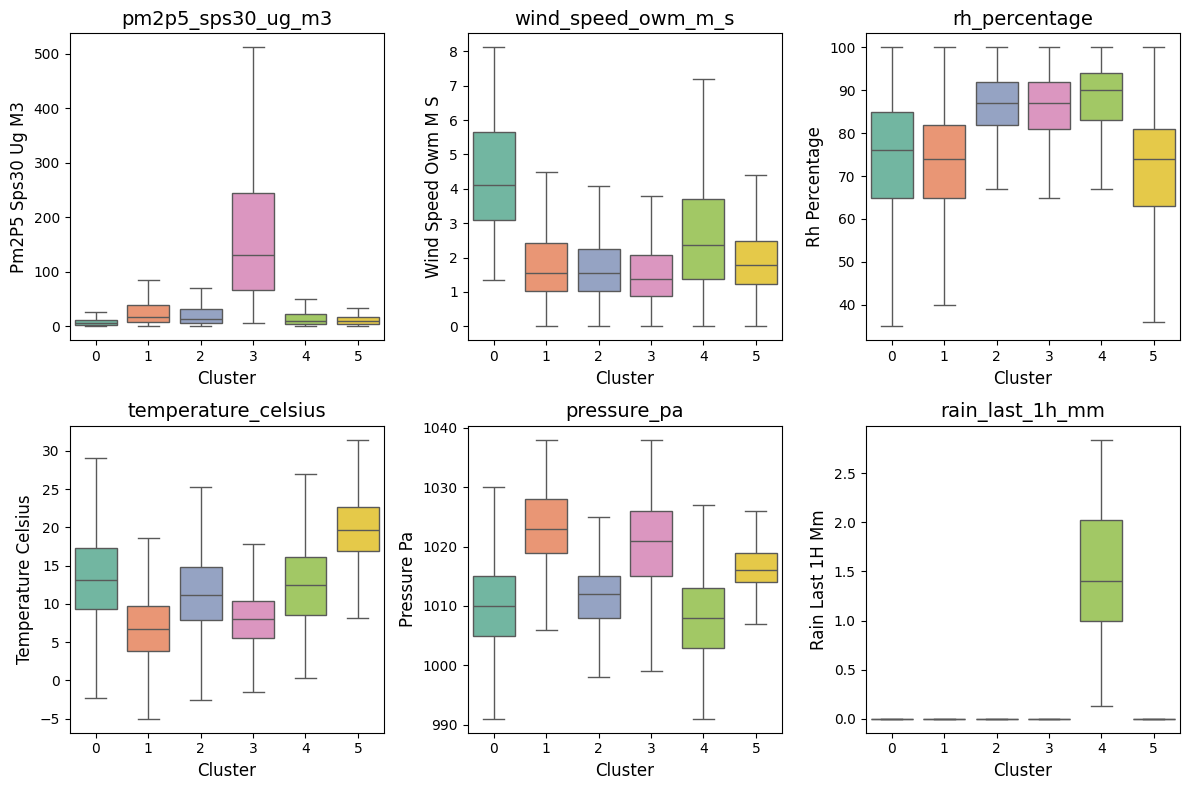

In [79]:
plt.figure(figsize = (12,8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    cluster_avarages_plot=sea.boxplot(x='Cluster K-Means', y=feature, data=series_analysis_df, palette="Set2", showfliers=False)

    plt.title(f"{feature}", fontsize=14)
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel(f"{feature.replace('_', ' ').title()}", fontsize=12)

plt.tight_layout()

print(citta_italiane)

Analisi Completa dei Cluster e Confronto con le Condizioni Climatiche Reali:
L'analisi si basa sul grafico dei boxplot delle variabili climatiche e sulla tabella delle città italiane con i relativi cluster.

- Cluster 2: Città con alta popolazione e condizioni umide
    - Città incluse: Roma, Napoli, Venezia, Bari, Messina, Padova, Trieste, Taranto, Reggio Calabria, Perugia.
    - Caratteristiche climatiche dal grafico:  
    - PM2.5: Livelli di particolato relativamente bassi, con una distribuzione stretta e pochi outlier.
    - Velocità del vento: Moderata, con valori medi intorno a 2 m/s.
    - Umidità relativa: Alta, con una mediana vicina all'80/90%.
    - Temperatura: Valori medi, con una mediana intorno ai 10°C.
    - Pressione atmosferica: Relativamente bassa.
    - Pioggia: Praticamente assente.

Osservazioni:
Questo cluster rappresenta città situate principalmente nel centro-sud Italia e lungo la costa, caratterizzate da alta umidità e temperature miti.

- Cluster 5: Città con condizioni più secche e ventose e alta altitudine (considerando alta >=50)
    - Città incluse: Milano, Torino, Firenze, Cagliari, Bologna, Genova, Verona, Brescia, Parma.
    - Caratteristiche climatiche dal grafico:
    - PM2.5: Livelli di particolato bassi, simili al Cluster 2.
    - Velocità del vento: Simile al Cluster 2, con una mediana intorno a 3 m/s.
    - Umidità relativa: Più bassa rispetto al Cluster 2, con una mediana intorno al 70%.
    - Temperatura: Valori alti, più alti rispetto al Cluster 2.
    - Pressione atmosferica: Relativamente alta.
    - Pioggia: Praticamente assente.

Osservazioni:
Questo cluster rappresenta città del nord e del centro Italia, caratterizzate da condizioni più secche e ventose.

Le condizioni climatiche attuali in Italia confermano le caratteristiche dei cluster identificati. Le città del Cluster 2 sono caratterizzate da alta umidità, temperature miti e scarsa pioggia, mentre le città del Cluster 5 presentano condizioni più secche, temperature leggermente più alte e vento moderato.
